In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error
pd.set_option('display.max_columns', None)
from IPython.display import display
import lightgbm as lgb
import numpy as np
import optuna


data = pd.read_csv("./preprocessed_data.csv")
data.drop_duplicates(subset="link")

,Unnamed: 0,title,home_type,link,garage,price,description,home_size,home_area,floor,elevator,price_per_sqr_meter,city,source,neighborhood,price_per_sqr_meter_bin,price_bin,home_area_bin,street_names
0,0,apartamento t0 rua eleuterio teixeira 8 capari...,apartamento,https://www.idealista.pt/imovel/33394837/,No,1000,"Estúdio com muita luz, casa de banho com duche...",T0,50,0.0,False,20.000000,Almada,idealista,almada,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]",almada
1,1,apartamento t0 sao joao caparica costa caparica,apartamento,https://www.idealista.pt/imovel/33182313/,No,1250,"Apartamento T0, com vista de Mar.\nNão perca a...",T0,60,10.0,True,20.833333,Almada,idealista,costa caparica,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]",costa caparica
2,2,apartamento t0 sao joao caparica costa caparica,apartamento,https://www.idealista.pt/imovel/33225472/,No,1200,Não perca a oportunidade de viver num apartame...,T0,57,6.0,True,21.052632,Almada,idealista,costa caparica,"(18.686, 23.248]","(355.38, 1364.8]","(42.92, 71.84]",costa caparica
3,3,apartamento t0 avenida liberdade 5 caparica tr...,apartamento,https://www.idealista.pt/imovel/33132721/,No,1200,"Excelente apartamento t1 na Trafaria, a 2 minu...",T0,50,1.0,False,24.000000,Almada,idealista,almada,"(23.248, 27.81]","(355.38, 1364.8]","(42.92, 71.84]",almada
4,4,apartamento t1 almada,apartamento,https://www.idealista.pt/imovel/33394381/,No,918,Apartamento de tipologia T1 em prédio totalmen...,T1,55,0.0,False,16.690909,Almada,idealista,apartamento t1 almada,"(14.124, 18.686]","(355.38, 1364.8]","(42.92, 71.84]",apartamento t1 almada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7322,7322,apartamento t3 rua senhora graca repeses sao s...,apartamento,https://www.idealista.pt/imovel/33389978/,No,750,Apartamento com 3 quartos com moveis\nCozinha ...,T3,110,2.0,False,6.818182,Viseu,idealista,viseu,"(4.886, 9.562]","(355.38, 1364.8]","(100.76, 129.68]",viseu
7323,7323,apartamento t3 avenida doutor antonio jose alm...,apartamento,https://www.idealista.pt/imovel/30425307/,No,880,Apartamento no centro de Viseu no último andar...,T3,140,4.0,True,6.285714,Viseu,idealista,viseu,"(4.886, 9.562]","(355.38, 1364.8]","(129.68, 158.6]",avenida doutor antonio jose
7324,7324,apartamento t3 avenida belgica 42 aguieira s...,apartamento,https://www.idealista.pt/imovel/33355326/,No,700,NaN,T3,86,1.0,False,8.139535,Viseu,idealista,viseu,"(4.886, 9.562]","(355.38, 1364.8]","(71.84, 100.76]",santiago viseu
7325,7325,apartamento t3 rua antonio gois guerreiro 185 ...,apartamento,https://www.idealista.pt/imovel/33358685/,No,1200,NaN,T3,100,5.0,True,12.000000,Viseu,idealista,viseu,"(9.562, 14.124]","(355.38, 1364.8]","(71.84, 100.76]",viseu


In [5]:
selected_features = ["home_type", "garage", "home_size", "floor", "elevator", "city", "neighborhood", "home_area", "street_names"]
target = ["price"]

data = data[selected_features + target]

In [6]:
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type == 'bool':
        data[c] = data[c].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327 entries, 0 to 7326
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   home_type     7325 non-null   category
 1   garage        7327 non-null   category
 2   home_size     7327 non-null   category
 3   floor         7327 non-null   float64 
 4   elevator      7327 non-null   category
 5   city          7327 non-null   category
 6   neighborhood  7327 non-null   category
 7   home_area     7327 non-null   int64   
 8   street_names  7327 non-null   category
 9   price         7327 non-null   int64   
dtypes: category(7), float64(1), int64(2)
memory usage: 254.2 KB


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target), 
                                                    data[target], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [8]:


"""
HEAVY UNBALANCED DATASETS

max_bin: keep it only for memory pressure, not to tune (otherwise overfitting)
learning rate: keep it only for training speed, not to tune (otherwise overfitting)
n_estimators: must be infinite (like 9999999) and use early stopping to auto-tune (otherwise overfitting)
num_leaves: [7, 4095]
max_depth: [2, 63] and infinite (I personally saw metric performance increases with such 63 depth with small number of leaves on sparse unbalanced datasets)
scale_pos_weight: [1, 10000] (if over 10000, something might be wrong because I never saw it that good after 5000)
min_child_weight: [0.01, (sample size / 1000)] if you are using logloss (think about the hessian possible value range before putting "sample size / 1000", it is dataset-dependent and loss-dependent)
subsample: [0.4, 1]
bagging_freq: only 1, keep as is (otherwise overfitting)
colsample_bytree: [0.4, 1]
is_unbalance: false (make your own weighting with scale_pos_weight)
USE A CUSTOM METRIC (to reflect reality without weighting, otherwise you have weights inside your metric with premade metrics like xgboost)

"""
def callback_model(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

# Assuming X_train and y_train are already defined and available
evals = {} # initializing in global scope
def objective(trial):
    # Train/test split
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    evals = {}
    # Suggest values for the hyperparameters
    param = {
        'objective': 'tweedie',
        'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
        'metric': 'rmse', 
        'verbosity': -1,  
        # 'boosting_type': 'rf',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 2.0),
        'num_leaves': trial.suggest_int('num_leaves', 32, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.4, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.2),
        'n_estimators': 3000
    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train_split, 
                         label=y_train_split)
    dvalid = lgb.Dataset(X_val_split, 
                         label=y_val_split)

    # Train the model
    gbm = lgb.train(param, dtrain, 
                    valid_sets=[dvalid],
                    callbacks = [
                        lgb.early_stopping(stopping_rounds= 100),
                        lgb.record_evaluation(evals),
                    ])

    # Predict on validation set
    preds = gbm.predict(X_val_split, 
                        num_iteration=gbm.best_iteration)
    
    trial.set_user_attr(key="best_booster", value=gbm)
    
    # Calculate RMSE
    rmse = mean_squared_error(y_val_split, 
                              preds, 
                              squared=False)
    return rmse

In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, 
               n_trials=200,
               callbacks=[callback_model])  # Specify the number of trials

[I 2024-05-13 20:28:00,188] A new study created in memory with name: no-name-c14a90a4-9fce-412d-ac14-d9674aaa263c
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:01,110] Trial 0 finished with value: 797.8613916062162 and parameters: {'tweedie_variance_power': 1.2800247429057694, 'lambda_l1': 0.5283908925026495, 'lambda_l2': 0.020715604968383143, 'num_leaves': 165, 'feature_fraction': 0.8196282005385789, 'bagging_fraction': 0.9830090077388808, 'colsample_bytree': 0.6970538443789548, 'min_child_samples': 96, 'learning_rate': 0.06324193961661581}. Best is trial 0 with value: 797.8613916062162.


Early stopping, best iteration is:
[111]	valid_0's rmse: 797.861
Training until validation scores don't improve for 100 rounds


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Early stopping, best iteration is:
[176]	valid_0's rmse: 804.48
Training until validation scores don't improve for 100 rounds


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Early stopping, best iteration is:
[168]	valid_0's rmse: 789.873


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:04,839] Trial 2 finished with value: 789.8732786712244 and parameters: {'tweedie_variance_power': 1.4581069459703937, 'lambda_l1': 0.5074630242966394, 'lambda_l2': 0.011944565742765346, 'num_leaves': 219, 'feature_fraction': 0.7970904519750128, 'bagging_fraction': 0.9384508834957556, 'colsample_bytree': 0.6982970498974578, 'min_child_samples': 10, 'learning_rate': 0.03124939215842301}. Best is trial 2 with value: 789.8732786712244.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's rmse: 785.679


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:06,974] Trial 3 finished with value: 785.678549199909 and parameters: {'tweedie_variance_power': 1.774270946008337, 'lambda_l1': 0.10343675966006687, 'lambda_l2': 0.006028009978260077, 'num_leaves': 122, 'feature_fraction': 0.7434971194045213, 'bagging_fraction': 0.5710594026242568, 'colsample_bytree': 0.9883216484723877, 'min_child_samples': 37, 'learning_rate': 0.013136053081809849}. Best is trial 3 with value: 785.678549199909.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:08,265] Trial 4 finished with value: 811.5697146428321 and parameters: {'tweedie_variance_power': 1.1819057310684633, 'lambda_l1': 0.01365874486883935, 'lambda_l2': 0.7329242432171641, 'num_leaves': 41, 'feature_fraction': 0.48767845215610156, 'bagging_fraction': 0.4570411504835157, 'colsample_bytree': 0.48763093770504706, 'min_child_samples': 45, 'learning_rate': 0.02014349469868479}. Best is trial 3 with value: 785.678549199909.


Early stopping, best iteration is:
[228]	valid_0's rmse: 811.57


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's rmse: 791.69


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:09,037] Trial 5 finished with value: 791.6895191275905 and parameters: {'tweedie_variance_power': 1.2369943644596524, 'lambda_l1': 0.12753221460253522, 'lambda_l2': 0.0019507974474855464, 'num_leaves': 44, 'feature_fraction': 0.45164288998803487, 'bagging_fraction': 0.7552237914380351, 'colsample_bytree': 0.4462217730338648, 'min_child_samples': 71, 'learning_rate': 0.1284726765978865}. Best is trial 3 with value: 785.678549199909.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's rmse: 794.587


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:11,891] Trial 6 finished with value: 794.5867824758705 and parameters: {'tweedie_variance_power': 1.4120016903739385, 'lambda_l1': 0.11632286145831358, 'lambda_l2': 0.0020960577607884866, 'num_leaves': 91, 'feature_fraction': 0.5567206205388684, 'bagging_fraction': 0.6961389942467151, 'colsample_bytree': 0.6499160600793366, 'min_child_samples': 68, 'learning_rate': 0.02043149892015667}. Best is trial 3 with value: 785.678549199909.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:12,906] Trial 7 finished with value: 798.5120449064977 and parameters: {'tweedie_variance_power': 1.6348828063752945, 'lambda_l1': 0.05646574919275252, 'lambda_l2': 0.013074910474433168, 'num_leaves': 148, 'feature_fraction': 0.6842736430097811, 'bagging_fraction': 0.9649864499645241, 'colsample_bytree': 0.4274876598330864, 'min_child_samples': 47, 'learning_rate': 0.06716469651940529}. Best is trial 3 with value: 785.678549199909.


Early stopping, best iteration is:
[79]	valid_0's rmse: 798.512


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:13,819] Trial 8 finished with value: 818.3285812079744 and parameters: {'tweedie_variance_power': 1.0432132410361032, 'lambda_l1': 0.002383571733180551, 'lambda_l2': 0.2134994579408974, 'num_leaves': 202, 'feature_fraction': 0.9575609366613125, 'bagging_fraction': 0.6616871973526376, 'colsample_bytree': 0.724339885545541, 'min_child_samples': 58, 'learning_rate': 0.06673605565385328}. Best is trial 3 with value: 785.678549199909.


Early stopping, best iteration is:
[86]	valid_0's rmse: 818.329


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:14,781] Trial 9 finished with value: 788.2921804639203 and parameters: {'tweedie_variance_power': 1.057893892746452, 'lambda_l1': 0.8138777826560576, 'lambda_l2': 0.008527003675209444, 'num_leaves': 197, 'feature_fraction': 0.4432387815434151, 'bagging_fraction': 0.4627097115733945, 'colsample_bytree': 0.7123964969516423, 'min_child_samples': 58, 'learning_rate': 0.08082988459056639}. Best is trial 3 with value: 785.678549199909.


Early stopping, best iteration is:
[63]	valid_0's rmse: 788.292


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[635]	valid_0's rmse: 792.239


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:19,774] Trial 10 finished with value: 792.2389148316079 and parameters: {'tweedie_variance_power': 1.798305790141695, 'lambda_l1': 0.01250582309929307, 'lambda_l2': 0.13573676730957043, 'num_leaves': 94, 'feature_fraction': 0.9992454440091822, 'bagging_fraction': 0.5606211915830955, 'colsample_bytree': 0.9942569424072615, 'min_child_samples': 24, 'learning_rate': 0.006968808826975472}. Best is trial 3 with value: 785.678549199909.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:20,901] Trial 11 finished with value: 777.8767354580984 and parameters: {'tweedie_variance_power': 1.5798462591222908, 'lambda_l1': 1.981572066556889, 'lambda_l2': 0.004095885353313602, 'num_leaves': 190, 'feature_fraction': 0.4096605428949251, 'bagging_fraction': 0.4071933046653375, 'colsample_bytree': 0.9964473932375826, 'min_child_samples': 32, 'learning_rate': 0.19785126907787226}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[58]	valid_0's rmse: 777.877
Training until validation scores don't improve for 100 rounds


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Early stopping, best iteration is:
[513]	valid_0's rmse: 781.551


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:24,383] Trial 12 finished with value: 781.551348691243 and parameters: {'tweedie_variance_power': 1.5998512295768768, 'lambda_l1': 1.736152990441757, 'lambda_l2': 0.0010281543349174324, 'num_leaves': 255, 'feature_fraction': 0.6117685189705852, 'bagging_fraction': 0.40319184181700546, 'colsample_bytree': 0.9764881778582115, 'min_child_samples': 32, 'learning_rate': 0.009762876644213773}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:25,530] Trial 13 finished with value: 809.1402134794777 and parameters: {'tweedie_variance_power': 1.5015554437195908, 'lambda_l1': 1.7917842008937577, 'lambda_l2': 0.0014371880307027327, 'num_leaves': 243, 'feature_fraction': 0.5825308541837124, 'bagging_fraction': 0.403699570680398, 'colsample_bytree': 0.8400127019369082, 'min_child_samples': 29, 'learning_rate': 0.18927559320970141}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[135]	valid_0's rmse: 809.14


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[857]	valid_0's rmse: 783.137


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:31,098] Trial 14 finished with value: 783.1369459832225 and parameters: {'tweedie_variance_power': 1.5845548628287875, 'lambda_l1': 1.911145491776567, 'lambda_l2': 0.00364083697221858, 'num_leaves': 247, 'feature_fraction': 0.40833978901458645, 'bagging_fraction': 0.4032293345158453, 'colsample_bytree': 0.8776929080057545, 'min_child_samples': 19, 'learning_rate': 0.005285879993665172}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:32,361] Trial 15 finished with value: 808.8694876218991 and parameters: {'tweedie_variance_power': 1.6195103632332317, 'lambda_l1': 0.2956573977647777, 'lambda_l2': 0.0010523462143349656, 'num_leaves': 180, 'feature_fraction': 0.5353360074609084, 'bagging_fraction': 0.5139139942576422, 'colsample_bytree': 0.877925953352961, 'min_child_samples': 35, 'learning_rate': 0.18932597695346576}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[128]	valid_0's rmse: 808.869


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[620]	valid_0's rmse: 801.863


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:41,009] Trial 16 finished with value: 801.8631201140635 and parameters: {'tweedie_variance_power': 1.3883195228133713, 'lambda_l1': 1.333389114187078, 'lambda_l2': 0.0034524375225661397, 'num_leaves': 223, 'feature_fraction': 0.4029512556775683, 'bagging_fraction': 0.5007252078088243, 'colsample_bytree': 0.574242479933302, 'min_child_samples': 12, 'learning_rate': 0.010124804878534946}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[561]	valid_0's rmse: 785.943


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:45,864] Trial 17 finished with value: 785.9429606027602 and parameters: {'tweedie_variance_power': 1.5252205477655496, 'lambda_l1': 0.2791729318996432, 'lambda_l2': 0.0011269488240248388, 'num_leaves': 249, 'feature_fraction': 0.6128341650395157, 'bagging_fraction': 0.5963758865513622, 'colsample_bytree': 0.8257761033666453, 'min_child_samples': 44, 'learning_rate': 0.010203590656233032}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:48,305] Trial 18 finished with value: 784.5661870576372 and parameters: {'tweedie_variance_power': 1.7136209156156912, 'lambda_l1': 0.9965919499244718, 'lambda_l2': 0.004099285344312948, 'num_leaves': 176, 'feature_fraction': 0.5109604037175328, 'bagging_fraction': 0.40497731990023683, 'colsample_bytree': 0.9458830081867359, 'min_child_samples': 33, 'learning_rate': 0.039140279803411865}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[169]	valid_0's rmse: 784.566


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:51,522] Trial 19 finished with value: 791.3337070163551 and parameters: {'tweedie_variance_power': 1.6788165419596617, 'lambda_l1': 0.2784281382859077, 'lambda_l2': 0.021582978285084087, 'num_leaves': 217, 'feature_fraction': 0.6061561411094111, 'bagging_fraction': 0.4923938539955561, 'colsample_bytree': 0.7933723968345782, 'min_child_samples': 20, 'learning_rate': 0.12266349512885528}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[158]	valid_0's rmse: 791.334


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	valid_0's rmse: 802.17


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:28:54,210] Trial 20 finished with value: 802.1699877198488 and parameters: {'tweedie_variance_power': 1.5420985533337332, 'lambda_l1': 1.9063351291576687, 'lambda_l2': 0.04285239324867592, 'num_leaves': 255, 'feature_fraction': 0.4882101943855697, 'bagging_fraction': 0.6197661746049414, 'colsample_bytree': 0.9322084981095656, 'min_child_samples': 51, 'learning_rate': 0.019755345816800142}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[832]	valid_0's rmse: 782.939


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:10,873] Trial 21 finished with value: 782.938671792934 and parameters: {'tweedie_variance_power': 1.5692495574137937, 'lambda_l1': 0.8220713155554377, 'lambda_l2': 0.0031809991317723997, 'num_leaves': 234, 'feature_fraction': 0.4059357444794236, 'bagging_fraction': 0.4002338276186097, 'colsample_bytree': 0.895445126071269, 'min_child_samples': 19, 'learning_rate': 0.005838279835892198}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[975]	valid_0's rmse: 781.401


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:20,336] Trial 22 finished with value: 781.4009425147725 and parameters: {'tweedie_variance_power': 1.58042737869349, 'lambda_l1': 0.8629193513352952, 'lambda_l2': 0.002262518079613267, 'num_leaves': 229, 'feature_fraction': 0.4707187056733032, 'bagging_fraction': 0.45482417835458866, 'colsample_bytree': 0.9149814081557667, 'min_child_samples': 26, 'learning_rate': 0.005101040098717683}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1659]	valid_0's rmse: 787.514


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:31,331] Trial 23 finished with value: 787.513600161119 and parameters: {'tweedie_variance_power': 1.470140324870073, 'lambda_l1': 0.8920219646350827, 'lambda_l2': 0.0026168146662088124, 'num_leaves': 205, 'feature_fraction': 0.5151394441540947, 'bagging_fraction': 0.45143844752274065, 'colsample_bytree': 0.9987328452919633, 'min_child_samples': 39, 'learning_rate': 0.007445131936216081}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1093]	valid_0's rmse: 782.425


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:42,236] Trial 24 finished with value: 782.4249673729166 and parameters: {'tweedie_variance_power': 1.698487355243795, 'lambda_l1': 0.5072530273883928, 'lambda_l2': 0.00572879274143617, 'num_leaves': 192, 'feature_fraction': 0.4701643699907113, 'bagging_fraction': 0.532919486823902, 'colsample_bytree': 0.7833581983475677, 'min_child_samples': 27, 'learning_rate': 0.0053025338010315596}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[601]	valid_0's rmse: 783.777


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:47,845] Trial 25 finished with value: 783.7766208454346 and parameters: {'tweedie_variance_power': 1.6315818848105992, 'lambda_l1': 1.8144465783427595, 'lambda_l2': 0.001033760518222265, 'num_leaves': 223, 'feature_fraction': 0.556795317968271, 'bagging_fraction': 0.4621936424859998, 'colsample_bytree': 0.9146089344324353, 'min_child_samples': 28, 'learning_rate': 0.008555048006011978}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's rmse: 791.162


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:29:51,654] Trial 26 finished with value: 791.1621090682663 and parameters: {'tweedie_variance_power': 1.562238721608877, 'lambda_l1': 1.0778615217228071, 'lambda_l2': 0.0020337719035637726, 'num_leaves': 154, 'feature_fraction': 0.5211604505278398, 'bagging_fraction': 0.5136392000796763, 'colsample_bytree': 0.8604707706289529, 'min_child_samples': 39, 'learning_rate': 0.013174512596806957}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1018]	valid_0's rmse: 784.188


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:07,355] Trial 27 finished with value: 784.1880774645879 and parameters: {'tweedie_variance_power': 1.3976601536924993, 'lambda_l1': 0.5371679654026995, 'lambda_l2': 0.005432634817540346, 'num_leaves': 230, 'feature_fraction': 0.4485487706825914, 'bagging_fraction': 0.4512549937010987, 'colsample_bytree': 0.9313908345755397, 'min_child_samples': 17, 'learning_rate': 0.005078180256085939}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[671]	valid_0's rmse: 786.658


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:11,444] Trial 28 finished with value: 786.6583591513934 and parameters: {'tweedie_variance_power': 1.5115430371114875, 'lambda_l1': 0.21377007012037447, 'lambda_l2': 0.001767716548328236, 'num_leaves': 177, 'feature_fraction': 0.6438417123535177, 'bagging_fraction': 0.5490728150365732, 'colsample_bytree': 0.7948757406878828, 'min_child_samples': 54, 'learning_rate': 0.006977398447186978}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:12,744] Trial 29 finished with value: 801.4065223580812 and parameters: {'tweedie_variance_power': 1.3286736115939168, 'lambda_l1': 0.5649798211896112, 'lambda_l2': 0.0020257998612457067, 'num_leaves': 163, 'feature_fraction': 0.5642935905052765, 'bagging_fraction': 0.48961129420579486, 'colsample_bytree': 0.9499978894686545, 'min_child_samples': 98, 'learning_rate': 0.047340429389803915}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[246]	valid_0's rmse: 801.407
Training until validation scores don't improve for 100 rounds


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Early stopping, best iteration is:
[273]	valid_0's rmse: 795.779


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[914]	valid_0's rmse: 782.162


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:22,234] Trial 31 finished with value: 782.1615715248887 and parameters: {'tweedie_variance_power': 1.6751365493916321, 'lambda_l1': 0.557592748443679, 'lambda_l2': 0.004685056992234996, 'num_leaves': 193, 'feature_fraction': 0.45443208564740056, 'bagging_fraction': 0.4389152937842166, 'colsample_bytree': 0.8401307708043132, 'min_child_samples': 27, 'learning_rate': 0.0060010591804302935}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:24,988] Trial 32 finished with value: 817.0241948868608 and parameters: {'tweedie_variance_power': 1.6448971955677787, 'lambda_l1': 0.7269144460621318, 'lambda_l2': 0.0029359324226425638, 'num_leaves': 188, 'feature_fraction': 0.4420978935505612, 'bagging_fraction': 0.43603183396875916, 'colsample_bytree': 0.8290391817229662, 'min_child_samples': 89, 'learning_rate': 0.006432324007554398}. Best is trial 11 with value: 777.8767354580984.


Early stopping, best iteration is:
[595]	valid_0's rmse: 817.024


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's rmse: 784.455


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:31,342] Trial 33 finished with value: 784.4551762160277 and parameters: {'tweedie_variance_power': 1.5874910663433297, 'lambda_l1': 0.4788491956573666, 'lambda_l2': 0.0014468825425598486, 'num_leaves': 236, 'feature_fraction': 0.4878312252790501, 'bagging_fraction': 0.4826786074636213, 'colsample_bytree': 0.8885239123394909, 'min_child_samples': 31, 'learning_rate': 0.008473876570816984}. Best is trial 11 with value: 777.8767354580984.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[726]	valid_0's rmse: 775.267


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:36,972] Trial 34 finished with value: 775.2670813980352 and parameters: {'tweedie_variance_power': 1.763761856460547, 'lambda_l1': 1.2644901667453972, 'lambda_l2': 0.01120811346158702, 'num_leaves': 121, 'feature_fraction': 0.5221097202373616, 'bagging_fraction': 0.4326834353920705, 'colsample_bytree': 0.9992038631336804, 'min_child_samples': 24, 'learning_rate': 0.009181803402111131}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's rmse: 798.468


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:40,293] Trial 35 finished with value: 798.4675718168738 and parameters: {'tweedie_variance_power': 1.7556304303922847, 'lambda_l1': 1.2065719320689812, 'lambda_l2': 0.009996888491037526, 'num_leaves': 127, 'feature_fraction': 0.5474634093420571, 'bagging_fraction': 0.5340514069447048, 'colsample_bytree': 0.9566679870191628, 'min_child_samples': 13, 'learning_rate': 0.024436791569672985}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[601]	valid_0's rmse: 783.574


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:46,129] Trial 36 finished with value: 783.5740903852706 and parameters: {'tweedie_variance_power': 1.799838985614188, 'lambda_l1': 1.3733618661723799, 'lambda_l2': 0.007733508924560555, 'num_leaves': 107, 'feature_fraction': 0.5908300103525488, 'bagging_fraction': 0.4364651804966925, 'colsample_bytree': 0.9928872196328941, 'min_child_samples': 23, 'learning_rate': 0.010471236347113425}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[273]	valid_0's rmse: 783.796


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:48,707] Trial 37 finished with value: 783.7962683072137 and parameters: {'tweedie_variance_power': 1.4648634412357382, 'lambda_l1': 0.39866921887347084, 'lambda_l2': 0.016429087034676878, 'num_leaves': 63, 'feature_fraction': 0.7164092312032488, 'bagging_fraction': 0.4761299631404754, 'colsample_bytree': 0.9100408013347917, 'min_child_samples': 44, 'learning_rate': 0.0171979474126883}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's rmse: 792.812


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:51,309] Trial 38 finished with value: 792.8120657034829 and parameters: {'tweedie_variance_power': 1.7519379953355871, 'lambda_l1': 0.8150869576030291, 'lambda_l2': 0.002649441940241114, 'num_leaves': 74, 'feature_fraction': 0.4960449227651398, 'bagging_fraction': 0.42723128171255687, 'colsample_bytree': 0.9571847469641569, 'min_child_samples': 39, 'learning_rate': 0.026053765362904675}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 788.107


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:30:57,497] Trial 39 finished with value: 788.1067562414593 and parameters: {'tweedie_variance_power': 1.6132570228841316, 'lambda_l1': 0.15596792909859597, 'lambda_l2': 0.0074819392713460055, 'num_leaves': 140, 'feature_fraction': 0.6542964581121526, 'bagging_fraction': 0.5160732396049184, 'colsample_bytree': 0.9091600484593743, 'min_child_samples': 10, 'learning_rate': 0.011634346101952237}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	valid_0's rmse: 788.536


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:01,702] Trial 40 finished with value: 788.5357374532646 and parameters: {'tweedie_variance_power': 1.6732086787158964, 'lambda_l1': 1.268657886066534, 'lambda_l2': 0.0015089461342459162, 'num_leaves': 213, 'feature_fraction': 0.5299454902086417, 'bagging_fraction': 0.4722063949208259, 'colsample_bytree': 0.9870604265618311, 'min_child_samples': 33, 'learning_rate': 0.016468808393912876}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 785.065


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:11,164] Trial 41 finished with value: 785.0649699228289 and parameters: {'tweedie_variance_power': 1.6811086250409122, 'lambda_l1': 0.6631537880486584, 'lambda_l2': 0.004980216383762218, 'num_leaves': 131, 'feature_fraction': 0.46602390612511657, 'bagging_fraction': 0.43664200823178395, 'colsample_bytree': 0.8589942623777249, 'min_child_samples': 23, 'learning_rate': 0.007667984056137269}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's rmse: 783.182


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:19,236] Trial 42 finished with value: 783.18234027401 and parameters: {'tweedie_variance_power': 1.7316014866887068, 'lambda_l1': 0.38529023402945767, 'lambda_l2': 0.0036736073196676515, 'num_leaves': 110, 'feature_fraction': 0.47220280919140817, 'bagging_fraction': 0.44186544038871806, 'colsample_bytree': 0.9985026471810637, 'min_child_samples': 26, 'learning_rate': 0.006291776365485906}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's rmse: 784.992


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:27,976] Trial 43 finished with value: 784.9923266691083 and parameters: {'tweedie_variance_power': 1.6594932266515419, 'lambda_l1': 0.6738786807942667, 'lambda_l2': 0.011300290883563945, 'num_leaves': 158, 'feature_fraction': 0.4275667205834752, 'bagging_fraction': 0.4005141579670936, 'colsample_bytree': 0.9408649486503841, 'min_child_samples': 17, 'learning_rate': 0.008580982347326871}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[850]	valid_0's rmse: 782.821


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:35,103] Trial 44 finished with value: 782.8212515463911 and parameters: {'tweedie_variance_power': 1.5952568771411995, 'lambda_l1': 0.9997259954985326, 'lambda_l2': 0.004647463064236839, 'num_leaves': 141, 'feature_fraction': 0.43768917208159663, 'bagging_fraction': 0.47136090628446253, 'colsample_bytree': 0.8445236979828644, 'min_child_samples': 30, 'learning_rate': 0.006157943178147854}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[647]	valid_0's rmse: 811.437


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:38,665] Trial 45 finished with value: 811.437414651321 and parameters: {'tweedie_variance_power': 1.7595006440805578, 'lambda_l1': 1.8296324613439152, 'lambda_l2': 0.002091098030308831, 'num_leaves': 239, 'feature_fraction': 0.4670055714160983, 'bagging_fraction': 0.5597136721422974, 'colsample_bytree': 0.8841928441413784, 'min_child_samples': 78, 'learning_rate': 0.012092480384650583}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1382]	valid_0's rmse: 790.991


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:49,968] Trial 46 finished with value: 790.9910536918284 and parameters: {'tweedie_variance_power': 1.5364582759657057, 'lambda_l1': 1.3968118617185439, 'lambda_l2': 0.0025422387392731185, 'num_leaves': 170, 'feature_fraction': 0.5010849401475237, 'bagging_fraction': 0.4262825917050718, 'colsample_bytree': 0.9160656817083322, 'min_child_samples': 35, 'learning_rate': 0.005205990838113997}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[571]	valid_0's rmse: 795.897


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:31:53,984] Trial 47 finished with value: 795.8970059195769 and parameters: {'tweedie_variance_power': 1.6249780881331946, 'lambda_l1': 0.09238387213570767, 'lambda_l2': 0.007348331197895537, 'num_leaves': 186, 'feature_fraction': 0.422411635013538, 'bagging_fraction': 0.7782357937911976, 'colsample_bytree': 0.9601548052382886, 'min_child_samples': 48, 'learning_rate': 0.009355627930709834}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[735]	valid_0's rmse: 780.025


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:04,281] Trial 48 finished with value: 780.0249446977622 and parameters: {'tweedie_variance_power': 1.7085411821216576, 'lambda_l1': 0.3981303769901806, 'lambda_l2': 0.001518869736284336, 'num_leaves': 256, 'feature_fraction': 0.5780470949833563, 'bagging_fraction': 0.4971659044943829, 'colsample_bytree': 0.8217885661610111, 'min_child_samples': 15, 'learning_rate': 0.00677685567341358}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[668]	valid_0's rmse: 792.421


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:13,616] Trial 49 finished with value: 792.4214277768216 and parameters: {'tweedie_variance_power': 1.7032668055301678, 'lambda_l1': 0.9411848816587738, 'lambda_l2': 0.0015745602854171572, 'num_leaves': 256, 'feature_fraction': 0.5602657693208484, 'bagging_fraction': 0.4973627858069503, 'colsample_bytree': 0.8744902333244046, 'min_child_samples': 13, 'learning_rate': 0.007219747559173486}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[536]	valid_0's rmse: 784.905


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:20,138] Trial 50 finished with value: 784.9054406442036 and parameters: {'tweedie_variance_power': 1.7983569349346538, 'lambda_l1': 0.3706584496720914, 'lambda_l2': 0.0013230602129134044, 'num_leaves': 246, 'feature_fraction': 0.589250087793024, 'bagging_fraction': 0.46100353852026726, 'colsample_bytree': 0.6860094893972625, 'min_child_samples': 21, 'learning_rate': 0.011477965575185819}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	valid_0's rmse: 783.361


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:28,258] Trial 51 finished with value: 783.3614430393186 and parameters: {'tweedie_variance_power': 1.6585383902273407, 'lambda_l1': 1.9969753213439854, 'lambda_l2': 0.0010372836255780284, 'num_leaves': 225, 'feature_fraction': 0.5230859425059142, 'bagging_fraction': 0.4274608050699828, 'colsample_bytree': 0.8151068066214882, 'min_child_samples': 15, 'learning_rate': 0.007993308181146257}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[907]	valid_0's rmse: 782.86


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:37,570] Trial 52 finished with value: 782.8596307344849 and parameters: {'tweedie_variance_power': 1.7137475694340756, 'lambda_l1': 0.7256718752529187, 'lambda_l2': 0.0040799692093693015, 'num_leaves': 115, 'feature_fraction': 0.4178864776999702, 'bagging_fraction': 0.45687925273185953, 'colsample_bytree': 0.9659290042672378, 'min_child_samples': 27, 'learning_rate': 0.00593016865285158}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's rmse: 786.755


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:43,997] Trial 53 finished with value: 786.7547711670495 and parameters: {'tweedie_variance_power': 1.582461172232647, 'lambda_l1': 1.3546802887280853, 'lambda_l2': 0.0024881280848818486, 'num_leaves': 199, 'feature_fraction': 0.4589075786510695, 'bagging_fraction': 0.4154895364294365, 'colsample_bytree': 0.8490110868838339, 'min_child_samples': 24, 'learning_rate': 0.009438072591829567}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1054]	valid_0's rmse: 786.808


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:32:51,839] Trial 54 finished with value: 786.8082210311986 and parameters: {'tweedie_variance_power': 1.548293718808789, 'lambda_l1': 0.5692060294269877, 'lambda_l2': 0.003346589632073773, 'num_leaves': 242, 'feature_fraction': 0.5402320840117959, 'bagging_fraction': 0.4953239728315316, 'colsample_bytree': 0.8983814302278025, 'min_child_samples': 41, 'learning_rate': 0.007029197652223654}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[906]	valid_0's rmse: 788.442


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:00,370] Trial 55 finished with value: 788.442125186663 and parameters: {'tweedie_variance_power': 1.5040724555291427, 'lambda_l1': 0.9740896148846838, 'lambda_l2': 0.0015737578466169678, 'num_leaves': 232, 'feature_fraction': 0.4974654877249059, 'bagging_fraction': 0.4162061937983934, 'colsample_bytree': 0.9284829451206797, 'min_child_samples': 35, 'learning_rate': 0.005802201512440083}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1061]	valid_0's rmse: 780.85


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:10,857] Trial 56 finished with value: 780.8495548862444 and parameters: {'tweedie_variance_power': 1.6282796952141574, 'lambda_l1': 0.21319077344784165, 'lambda_l2': 0.004051847369800615, 'num_leaves': 256, 'feature_fraction': 0.4018109581861138, 'bagging_fraction': 0.40244405809857503, 'colsample_bytree': 0.971997457034733, 'min_child_samples': 31, 'learning_rate': 0.0050356579843642444}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's rmse: 785.525


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:23,430] Trial 57 finished with value: 785.5252101692049 and parameters: {'tweedie_variance_power': 1.6145497796575823, 'lambda_l1': 0.23119227987569937, 'lambda_l2': 0.001972701512553832, 'num_leaves': 256, 'feature_fraction': 0.41236650939332403, 'bagging_fraction': 0.40072954431277097, 'colsample_bytree': 0.961938841643592, 'min_child_samples': 21, 'learning_rate': 0.005185252239933039}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[831]	valid_0's rmse: 788.946


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:31,309] Trial 58 finished with value: 788.9462146946382 and parameters: {'tweedie_variance_power': 1.479442957397975, 'lambda_l1': 1.4986085956825486, 'lambda_l2': 0.0012539660035799124, 'num_leaves': 248, 'feature_fraction': 0.4343941650628997, 'bagging_fraction': 0.4553504453045275, 'colsample_bytree': 0.9766136886670349, 'min_child_samples': 32, 'learning_rate': 0.0067531082151468125}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[797]	valid_0's rmse: 787.302


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:36,548] Trial 59 finished with value: 787.3018322751622 and parameters: {'tweedie_variance_power': 1.562888332636093, 'lambda_l1': 1.050180016157589, 'lambda_l2': 0.003115961127225945, 'num_leaves': 218, 'feature_fraction': 0.4076368021728007, 'bagging_fraction': 0.4739994252108952, 'colsample_bytree': 0.9250265293434838, 'min_child_samples': 62, 'learning_rate': 0.008184534811278793}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 805.177


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:39,969] Trial 60 finished with value: 805.1770477323696 and parameters: {'tweedie_variance_power': 1.4260917079746227, 'lambda_l1': 0.1570019781523052, 'lambda_l2': 0.0010105526786648928, 'num_leaves': 227, 'feature_fraction': 0.5723568908783001, 'bagging_fraction': 0.5184616616390496, 'colsample_bytree': 0.9972512552898343, 'min_child_samples': 17, 'learning_rate': 0.11166790343918617}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[871]	valid_0's rmse: 784.349


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:33:49,383] Trial 61 finished with value: 784.3492456362239 and parameters: {'tweedie_variance_power': 1.6468020032405326, 'lambda_l1': 0.38366343875427, 'lambda_l2': 0.0044165406442945405, 'num_leaves': 240, 'feature_fraction': 0.450532603912684, 'bagging_fraction': 0.44635595162885017, 'colsample_bytree': 0.872118162295525, 'min_child_samples': 29, 'learning_rate': 0.006235071847594411}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[920]	valid_0's rmse: 780.093


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:00,846] Trial 62 finished with value: 780.0932390265416 and parameters: {'tweedie_variance_power': 1.682775819110425, 'lambda_l1': 0.678249927949159, 'lambda_l2': 0.002326173754119104, 'num_leaves': 249, 'feature_fraction': 0.5096590390953232, 'bagging_fraction': 0.41925766988939106, 'colsample_bytree': 0.9349503945323551, 'min_child_samples': 24, 'learning_rate': 0.00557469488397145}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[687]	valid_0's rmse: 779.561


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:11,604] Trial 63 finished with value: 779.5610398615813 and parameters: {'tweedie_variance_power': 1.7057566951235805, 'lambda_l1': 1.6566237869054, 'lambda_l2': 0.0023779272302178697, 'num_leaves': 250, 'feature_fraction': 0.520260981443987, 'bagging_fraction': 0.4128844302896612, 'colsample_bytree': 0.9328864765738126, 'min_child_samples': 25, 'learning_rate': 0.007756413543301913}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[907]	valid_0's rmse: 778.535


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:21,244] Trial 64 finished with value: 778.5354121885622 and parameters: {'tweedie_variance_power': 1.7380743672333998, 'lambda_l1': 0.7912939071684645, 'lambda_l2': 0.0023219481727334906, 'num_leaves': 247, 'feature_fraction': 0.47972442600134535, 'bagging_fraction': 0.4207081686429777, 'colsample_bytree': 0.9339728823392314, 'min_child_samples': 24, 'learning_rate': 0.005464349831568115}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's rmse: 781.881


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:29,169] Trial 65 finished with value: 781.8814474756972 and parameters: {'tweedie_variance_power': 1.7647500450323144, 'lambda_l1': 0.6520741925411269, 'lambda_l2': 0.006342004710522877, 'num_leaves': 97, 'feature_fraction': 0.5092094385714225, 'bagging_fraction': 0.4216217734288581, 'colsample_bytree': 0.94129635658511, 'min_child_samples': 19, 'learning_rate': 0.0075081358793646835}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[703]	valid_0's rmse: 794.976


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:41,666] Trial 66 finished with value: 794.9760694732795 and parameters: {'tweedie_variance_power': 1.7163280797306275, 'lambda_l1': 1.5831675232556555, 'lambda_l2': 0.0031803995675060135, 'num_leaves': 247, 'feature_fraction': 0.48219830619506376, 'bagging_fraction': 0.4222621578118924, 'colsample_bytree': 0.8985222224853072, 'min_child_samples': 10, 'learning_rate': 0.0067728329380962096}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	valid_0's rmse: 781.267


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:34:50,530] Trial 67 finished with value: 781.2666716220762 and parameters: {'tweedie_variance_power': 1.6847094724530547, 'lambda_l1': 0.801758028287359, 'lambda_l2': 0.0017663841358280515, 'num_leaves': 253, 'feature_fraction': 0.5382627401589872, 'bagging_fraction': 0.41226062229969584, 'colsample_bytree': 0.9723389817065842, 'min_child_samples': 15, 'learning_rate': 0.009037829356990582}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[993]	valid_0's rmse: 780.122


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:06,460] Trial 68 finished with value: 780.1219848301308 and parameters: {'tweedie_variance_power': 1.737175301703696, 'lambda_l1': 1.099504797701217, 'lambda_l2': 0.003946638091250426, 'num_leaves': 235, 'feature_fraction': 0.484736776948221, 'bagging_fraction': 0.4835097485224956, 'colsample_bytree': 0.93744545010972, 'min_child_samples': 23, 'learning_rate': 0.005720018011332223}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(...

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1151]	valid_0's rmse: 780.205


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:20,773] Trial 69 finished with value: 780.2048626341215 and parameters: {'tweedie_variance_power': 1.7449154699984755, 'lambda_l1': 1.088755258300014, 'lambda_l2': 0.0022037112676526866, 'num_leaves': 235, 'feature_fraction': 0.5129800572045703, 'bagging_fraction': 0.48317572193588276, 'colsample_bytree': 0.9342306250467768, 'min_child_samples': 23, 'learning_rate': 0.005675044279088484}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	valid_0's rmse: 781.559


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:27,824] Trial 70 finished with value: 781.5586466628727 and parameters: {'tweedie_variance_power': 1.7770977148896954, 'lambda_l1': 1.6717776950452585, 'lambda_l2': 0.0028133773811519183, 'num_leaves': 217, 'feature_fraction': 0.4867541624816432, 'bagging_fraction': 0.5001894246202587, 'colsample_bytree': 0.8681061591605576, 'min_child_samples': 25, 'learning_rate': 0.010315226545646747}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1054]	valid_0's rmse: 780.359


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:39,457] Trial 71 finished with value: 780.35883958192 and parameters: {'tweedie_variance_power': 1.7364692619989217, 'lambda_l1': 0.997250421110923, 'lambda_l2': 0.0021543368218164562, 'num_leaves': 235, 'feature_fraction': 0.5136459238842223, 'bagging_fraction': 0.4827406871913492, 'colsample_bytree': 0.93397360024961, 'min_child_samples': 22, 'learning_rate': 0.005653284691743328}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[843]	valid_0's rmse: 781.242


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:48,916] Trial 72 finished with value: 781.2424448857944 and parameters: {'tweedie_variance_power': 1.7015028824743281, 'lambda_l1': 1.1492366538229561, 'lambda_l2': 0.002340538227670975, 'num_leaves': 208, 'feature_fraction': 0.5474259261373156, 'bagging_fraction': 0.44328905232103955, 'colsample_bytree': 0.894148615326936, 'min_child_samples': 19, 'learning_rate': 0.007750929351028985}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[928]	valid_0's rmse: 782.065


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:35:58,548] Trial 73 finished with value: 782.064961984255 and parameters: {'tweedie_variance_power': 1.7357509392761248, 'lambda_l1': 1.1968738194138855, 'lambda_l2': 0.0016414272332769876, 'num_leaves': 241, 'feature_fraction': 0.5137018978712016, 'bagging_fraction': 0.4591194757080533, 'colsample_bytree': 0.9414657220755016, 'min_child_samples': 15, 'learning_rate': 0.00574522576377965}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1038]	valid_0's rmse: 777.347


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:06,757] Trial 74 finished with value: 777.3474793494416 and parameters: {'tweedie_variance_power': 1.7696726839755073, 'lambda_l1': 1.5983568258882366, 'lambda_l2': 0.003736303079456944, 'num_leaves': 249, 'feature_fraction': 0.5324421848591773, 'bagging_fraction': 0.48281675913801964, 'colsample_bytree': 0.9127153437571441, 'min_child_samples': 24, 'learning_rate': 0.006712059527437093}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1006]	valid_0's rmse: 779.022


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:15,102] Trial 75 finished with value: 779.022222892355 and parameters: {'tweedie_variance_power': 1.776640062464562, 'lambda_l1': 1.6156084299100195, 'lambda_l2': 0.009265109929167284, 'num_leaves': 248, 'feature_fraction': 0.5379089213112888, 'bagging_fraction': 0.4426186394643041, 'colsample_bytree': 0.8179507147463552, 'min_child_samples': 29, 'learning_rate': 0.006657367052264022}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's rmse: 783.853


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:21,825] Trial 76 finished with value: 783.8527721232311 and parameters: {'tweedie_variance_power': 1.7794585417297024, 'lambda_l1': 1.4911266751464303, 'lambda_l2': 0.00987349449837407, 'num_leaves': 249, 'feature_fraction': 0.5338533161595703, 'bagging_fraction': 0.4313947687361585, 'colsample_bytree': 0.7720990439231751, 'min_child_samples': 36, 'learning_rate': 0.009044997536808985}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[993]	valid_0's rmse: 779.813


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:30,143] Trial 77 finished with value: 779.8126754602249 and parameters: {'tweedie_variance_power': 1.778930866573176, 'lambda_l1': 1.8629939459468388, 'lambda_l2': 0.005592998545928683, 'num_leaves': 223, 'feature_fraction': 0.5693416846489183, 'bagging_fraction': 0.4662406531986331, 'colsample_bytree': 0.8205489232940953, 'min_child_samples': 29, 'learning_rate': 0.00668270686580882}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1023]	valid_0's rmse: 780.008


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:38,105] Trial 78 finished with value: 780.0075019139949 and parameters: {'tweedie_variance_power': 1.7827643045143127, 'lambda_l1': 1.8529443920855748, 'lambda_l2': 0.013795211514231217, 'num_leaves': 222, 'feature_fraction': 0.5822524728364996, 'bagging_fraction': 0.46420389523446437, 'colsample_bytree': 0.8157827443331629, 'min_child_samples': 28, 'learning_rate': 0.006911469292625113}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[933]	valid_0's rmse: 780.708


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:45,117] Trial 79 finished with value: 780.7076430157939 and parameters: {'tweedie_variance_power': 1.7794779350311594, 'lambda_l1': 1.9173545589599728, 'lambda_l2': 0.006485167172018661, 'num_leaves': 211, 'feature_fraction': 0.5575441295138335, 'bagging_fraction': 0.46708348821785634, 'colsample_bytree': 0.8123682325663389, 'min_child_samples': 41, 'learning_rate': 0.008222659938361417}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[926]	valid_0's rmse: 780.41


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:36:52,485] Trial 80 finished with value: 780.4102631569648 and parameters: {'tweedie_variance_power': 1.794466486662723, 'lambda_l1': 1.5952003767323866, 'lambda_l2': 0.00879826766638534, 'num_leaves': 227, 'feature_fraction': 0.5966407444737423, 'bagging_fraction': 0.44493367941812584, 'colsample_bytree': 0.8597992001541114, 'min_child_samples': 29, 'learning_rate': 0.007424865608094814}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1054]	valid_0's rmse: 782.929


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:02,411] Trial 81 finished with value: 782.9289287503398 and parameters: {'tweedie_variance_power': 1.770536593819297, 'lambda_l1': 1.548683169670683, 'lambda_l2': 0.013597425037936928, 'num_leaves': 243, 'feature_fraction': 0.5668975393566618, 'bagging_fraction': 0.5049525955621068, 'colsample_bytree': 0.8106886429671989, 'min_child_samples': 33, 'learning_rate': 0.0066782310554930864}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[821]	valid_0's rmse: 781.755


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:12,505] Trial 82 finished with value: 781.7549823169454 and parameters: {'tweedie_variance_power': 1.71268992576377, 'lambda_l1': 1.9567814808021242, 'lambda_l2': 0.005870139840354407, 'num_leaves': 222, 'feature_fraction': 0.5755197706950395, 'bagging_fraction': 0.5338981532737503, 'colsample_bytree': 0.8261331149108052, 'min_child_samples': 27, 'learning_rate': 0.006523220759755613}. Best is trial 34 with value: 775.2670813980352.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's rmse: 774.208


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:19,706] Trial 83 finished with value: 774.207980762975 and parameters: {'tweedie_variance_power': 1.7560253467973967, 'lambda_l1': 1.2930015192110014, 'lambda_l2': 0.005036378703182684, 'num_leaves': 201, 'feature_fraction': 0.6226028304648594, 'bagging_fraction': 0.46457763639427924, 'colsample_bytree': 0.795228084566652, 'min_child_samples': 29, 'learning_rate': 0.007198494190797198}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's rmse: 781.287


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:24,707] Trial 84 finished with value: 781.2869821913222 and parameters: {'tweedie_variance_power': 1.7680664572100422, 'lambda_l1': 1.2938218702614368, 'lambda_l2': 0.005189979054556591, 'num_leaves': 200, 'feature_fraction': 0.6192402255238817, 'bagging_fraction': 0.4412147584521144, 'colsample_bytree': 0.7518043170836913, 'min_child_samples': 37, 'learning_rate': 0.010086852522053956}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's rmse: 778.169


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:32,813] Trial 85 finished with value: 778.1685627496256 and parameters: {'tweedie_variance_power': 1.7450432371980638, 'lambda_l1': 0.8564067317904276, 'lambda_l2': 0.008749434278315451, 'num_leaves': 183, 'feature_fraction': 0.5302382259956757, 'bagging_fraction': 0.46449527516240546, 'colsample_bytree': 0.8443208898708766, 'min_child_samples': 29, 'learning_rate': 0.00840328991201164}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	valid_0's rmse: 780.66


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:39,496] Trial 86 finished with value: 780.66035222089 and parameters: {'tweedie_variance_power': 1.7399437023148105, 'lambda_l1': 0.8461245083124797, 'lambda_l2': 0.007736054652443416, 'num_leaves': 171, 'feature_fraction': 0.5486609170397034, 'bagging_fraction': 0.47134465444385615, 'colsample_bytree': 0.8423108604689665, 'min_child_samples': 30, 'learning_rate': 0.008406007848048574}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[930]	valid_0's rmse: 786.616


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:47,603] Trial 87 finished with value: 786.615673006763 and parameters: {'tweedie_variance_power': 1.6619676882893617, 'lambda_l1': 1.282598904292424, 'lambda_l2': 0.009434357398588108, 'num_leaves': 182, 'feature_fraction': 0.5265897449362237, 'bagging_fraction': 0.4319941401544279, 'colsample_bytree': 0.9095073246985996, 'min_child_samples': 34, 'learning_rate': 0.007840064086954158}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:48,927] Trial 88 finished with value: 798.7971105780248 and parameters: {'tweedie_variance_power': 1.7567785255855894, 'lambda_l1': 0.8635733426456335, 'lambda_l2': 0.00506180456682879, 'num_leaves': 35, 'feature_fraction': 0.5272996566088521, 'bagging_fraction': 0.4593469606508202, 'colsample_bytree': 0.7971206774572861, 'min_child_samples': 20, 'learning_rate': 0.053375231684520553}. Best is trial 83 with value: 774.207980762975.


Early stopping, best iteration is:
[97]	valid_0's rmse: 798.797


C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'tweedie_variance_power': trial.suggest_loguniform('tweedie_variance_power', 1.0, 1.8),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 2.0),
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.sugge

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's rmse: 785.698


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:53,604] Trial 89 finished with value: 785.6980800905687 and parameters: {'tweedie_variance_power': 1.6999920373982218, 'lambda_l1': 1.5469394456363492, 'lambda_l2': 0.007088236627490444, 'num_leaves': 204, 'feature_fraction': 0.6072529824809966, 'bagging_fraction': 0.40894974569106746, 'colsample_bytree': 0.8801727076319876, 'min_child_samples': 26, 'learning_rate': 0.011018031445024274}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[794]	valid_0's rmse: 785.334


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:37:59,361] Trial 90 finished with value: 785.3338445751377 and parameters: {'tweedie_variance_power': 1.7271471805759275, 'lambda_l1': 1.1654911931124958, 'lambda_l2': 0.003547796994294308, 'num_leaves': 195, 'feature_fraction': 0.5500093085383571, 'bagging_fraction': 0.44032176784867016, 'colsample_bytree': 0.850206430415316, 'min_child_samples': 39, 'learning_rate': 0.009492718731352923}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1057]	valid_0's rmse: 780.953


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:06,554] Trial 91 finished with value: 780.9533203652488 and parameters: {'tweedie_variance_power': 1.7979711413762531, 'lambda_l1': 1.727806778059944, 'lambda_l2': 0.014663200337468318, 'num_leaves': 214, 'feature_fraction': 0.586576276575674, 'bagging_fraction': 0.453266475021484, 'colsample_bytree': 0.8336456757776151, 'min_child_samples': 28, 'learning_rate': 0.007214472450758499}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1053]	valid_0's rmse: 782.555


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:14,953] Trial 92 finished with value: 782.5549270244903 and parameters: {'tweedie_variance_power': 1.7580900187720396, 'lambda_l1': 1.9125276407322886, 'lambda_l2': 0.01742282528036443, 'num_leaves': 189, 'feature_fraction': 0.5638156741873968, 'bagging_fraction': 0.46838950257441814, 'colsample_bytree': 0.7861974131562974, 'min_child_samples': 32, 'learning_rate': 0.00628546602059637}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's rmse: 781.057


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:18,927] Trial 93 finished with value: 781.057132890989 and parameters: {'tweedie_variance_power': 1.6918315433681395, 'lambda_l1': 1.368203112837389, 'lambda_l2': 0.01152356710909224, 'num_leaves': 154, 'feature_fraction': 0.5997949509609561, 'bagging_fraction': 0.4133235144277078, 'colsample_bytree': 0.8796648696394028, 'min_child_samples': 26, 'learning_rate': 0.012837889891064009}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[533]	valid_0's rmse: 774.564


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:25,084] Trial 94 finished with value: 774.5636089893619 and parameters: {'tweedie_variance_power': 1.6493025265233439, 'lambda_l1': 1.608990796450269, 'lambda_l2': 0.008687586360290912, 'num_leaves': 131, 'feature_fraction': 0.6336948016970676, 'bagging_fraction': 0.48654744237114717, 'colsample_bytree': 0.9081416233520334, 'min_child_samples': 25, 'learning_rate': 0.00887877512510944}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[531]	valid_0's rmse: 787.484


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:31,510] Trial 95 finished with value: 787.4837553287163 and parameters: {'tweedie_variance_power': 1.6599172015907857, 'lambda_l1': 0.9724279168417134, 'lambda_l2': 0.005545499462545333, 'num_leaves': 136, 'feature_fraction': 0.49638513453031974, 'bagging_fraction': 0.4891674073899254, 'colsample_bytree': 0.9713186527621339, 'min_child_samples': 18, 'learning_rate': 0.008672945279859514}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 775.493


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:36,420] Trial 96 finished with value: 775.4931408350784 and parameters: {'tweedie_variance_power': 1.6388863273182637, 'lambda_l1': 1.4761677619819134, 'lambda_l2': 0.011517134753723882, 'num_leaves': 122, 'feature_fraction': 0.6337478972007642, 'bagging_fraction': 0.4276050918792068, 'colsample_bytree': 0.9071614850198108, 'min_child_samples': 25, 'learning_rate': 0.010522803950460893}. Best is trial 83 with value: 774.207980762975.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[434]	valid_0's rmse: 772.521


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:41,950] Trial 97 finished with value: 772.5209618139963 and parameters: {'tweedie_variance_power': 1.600022598535329, 'lambda_l1': 0.7678377636900147, 'lambda_l2': 0.008805709882270703, 'num_leaves': 116, 'feature_fraction': 0.6699978834480466, 'bagging_fraction': 0.43073240606935936, 'colsample_bytree': 0.9097150204638743, 'min_child_samples': 25, 'learning_rate': 0.010858888823967076}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 778.097


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:47,222] Trial 98 finished with value: 778.0967965432521 and parameters: {'tweedie_variance_power': 1.6394743590024632, 'lambda_l1': 0.7519442784178021, 'lambda_l2': 0.008692019290447018, 'num_leaves': 113, 'feature_fraction': 0.6384770749836363, 'bagging_fraction': 0.4305786735537341, 'colsample_bytree': 0.9073597635955164, 'min_child_samples': 21, 'learning_rate': 0.010900728231414828}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's rmse: 780.627


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:52,261] Trial 99 finished with value: 780.6267078351915 and parameters: {'tweedie_variance_power': 1.6034210595160403, 'lambda_l1': 0.4812325598104581, 'lambda_l2': 0.020900584546750298, 'num_leaves': 120, 'feature_fraction': 0.6357282782944997, 'bagging_fraction': 0.4283475301392917, 'colsample_bytree': 0.9075065598903111, 'min_child_samples': 21, 'learning_rate': 0.010664482561417298}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 777.681


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:38:57,298] Trial 100 finished with value: 777.6810881934296 and parameters: {'tweedie_variance_power': 1.6371131219391262, 'lambda_l1': 0.7655632645189874, 'lambda_l2': 0.011916628132753727, 'num_leaves': 99, 'feature_fraction': 0.6774743719557553, 'bagging_fraction': 0.40003895693068836, 'colsample_bytree': 0.9156446290128084, 'min_child_samples': 22, 'learning_rate': 0.012076807788739933}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	valid_0's rmse: 776.825


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:01,905] Trial 101 finished with value: 776.8253643649771 and parameters: {'tweedie_variance_power': 1.6442764933313636, 'lambda_l1': 0.7685230920139199, 'lambda_l2': 0.011691153187953971, 'num_leaves': 102, 'feature_fraction': 0.6685922580645371, 'bagging_fraction': 0.42778591393026305, 'colsample_bytree': 0.9162264326750698, 'min_child_samples': 22, 'learning_rate': 0.01141044256153934}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's rmse: 777.114


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:09,309] Trial 102 finished with value: 777.1137735771871 and parameters: {'tweedie_variance_power': 1.6271803795896944, 'lambda_l1': 0.6129265302460427, 'lambda_l2': 0.011226033002148892, 'num_leaves': 103, 'feature_fraction': 0.6729498847053718, 'bagging_fraction': 0.43288716897321927, 'colsample_bytree': 0.8948736612595369, 'min_child_samples': 17, 'learning_rate': 0.01213515754077035}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's rmse: 779.062


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:15,540] Trial 103 finished with value: 779.0616117431993 and parameters: {'tweedie_variance_power': 1.6408283206080094, 'lambda_l1': 0.6605958092954998, 'lambda_l2': 0.013073470379585048, 'num_leaves': 102, 'feature_fraction': 0.6782635985977977, 'bagging_fraction': 0.4003912055500696, 'colsample_bytree': 0.9573701232076428, 'min_child_samples': 17, 'learning_rate': 0.012096584800744105}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	valid_0's rmse: 777.137


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:20,179] Trial 104 finished with value: 777.1374441534026 and parameters: {'tweedie_variance_power': 1.63486470210479, 'lambda_l1': 0.5528297685218692, 'lambda_l2': 0.010997119389201917, 'num_leaves': 80, 'feature_fraction': 0.6632929398544676, 'bagging_fraction': 0.431963994816142, 'colsample_bytree': 0.8922384650388534, 'min_child_samples': 22, 'learning_rate': 0.011120867096150172}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[282]	valid_0's rmse: 788.608


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:23,976] Trial 105 finished with value: 788.6078828674008 and parameters: {'tweedie_variance_power': 1.605915175580179, 'lambda_l1': 0.5703737117490907, 'lambda_l2': 0.011395902699593053, 'num_leaves': 85, 'feature_fraction': 0.6591126457714926, 'bagging_fraction': 0.4507622194822851, 'colsample_bytree': 0.8894414253219652, 'min_child_samples': 12, 'learning_rate': 0.013283889411726887}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's rmse: 780.148


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:27,803] Trial 106 finished with value: 780.1480361409008 and parameters: {'tweedie_variance_power': 1.5812436933659397, 'lambda_l1': 0.9377444684330131, 'lambda_l2': 0.010991872274819176, 'num_leaves': 90, 'feature_fraction': 0.6741702284307091, 'bagging_fraction': 0.42105574941748153, 'colsample_bytree': 0.9178297398405401, 'min_child_samples': 22, 'learning_rate': 0.014612072427622667}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's rmse: 780.708


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:31,616] Trial 107 finished with value: 780.708090870812 and parameters: {'tweedie_variance_power': 1.609271675857637, 'lambda_l1': 1.1424640438814837, 'lambda_l2': 0.017306951448784105, 'num_leaves': 71, 'feature_fraction': 0.690023574792758, 'bagging_fraction': 0.4138137904965133, 'colsample_bytree': 0.9837357944103222, 'min_child_samples': 16, 'learning_rate': 0.009714883659787414}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[422]	valid_0's rmse: 778.648


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:36,678] Trial 108 finished with value: 778.6484649242332 and parameters: {'tweedie_variance_power': 1.626458721602609, 'lambda_l1': 0.44520494190079374, 'lambda_l2': 0.02393274429340591, 'num_leaves': 125, 'feature_fraction': 0.6498726964215651, 'bagging_fraction': 0.43261218810505536, 'colsample_bytree': 0.9521960430721843, 'min_child_samples': 19, 'learning_rate': 0.0114601145833425}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's rmse: 808.024


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:38,571] Trial 109 finished with value: 808.0243934445188 and parameters: {'tweedie_variance_power': 1.5605813181669226, 'lambda_l1': 0.636961384331603, 'lambda_l2': 0.007610959022533097, 'num_leaves': 104, 'feature_fraction': 0.6658990336803712, 'bagging_fraction': 0.4002034502511092, 'colsample_bytree': 0.8667385004329872, 'min_child_samples': 88, 'learning_rate': 0.014468011223112382}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 784.728


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:43,752] Trial 110 finished with value: 784.7278805265128 and parameters: {'tweedie_variance_power': 1.670838412700561, 'lambda_l1': 1.3380320805205463, 'lambda_l2': 0.006707301147856273, 'num_leaves': 117, 'feature_fraction': 0.7005460005586328, 'bagging_fraction': 0.4500136355740635, 'colsample_bytree': 0.8973949525024576, 'min_child_samples': 12, 'learning_rate': 0.009644762721817662}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[436]	valid_0's rmse: 779.219


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:49,096] Trial 111 finished with value: 779.2191760703685 and parameters: {'tweedie_variance_power': 1.6465208074882338, 'lambda_l1': 0.7552150340483058, 'lambda_l2': 0.010551836528894165, 'num_leaves': 112, 'feature_fraction': 0.639349748652055, 'bagging_fraction': 0.43594357864282784, 'colsample_bytree': 0.9053721441851402, 'min_child_samples': 21, 'learning_rate': 0.010818878523314845}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's rmse: 774.895


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:39:55,589] Trial 112 finished with value: 774.8948976167818 and parameters: {'tweedie_variance_power': 1.632337908115065, 'lambda_l1': 0.5601316369986408, 'lambda_l2': 0.008377472736104459, 'num_leaves': 131, 'feature_fraction': 0.6269270740327023, 'bagging_fraction': 0.42777064343114757, 'colsample_bytree': 0.9191845329877412, 'min_child_samples': 25, 'learning_rate': 0.010725409539476134}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[444]	valid_0's rmse: 773.359


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:02,677] Trial 113 finished with value: 773.3591949508622 and parameters: {'tweedie_variance_power': 1.5978113815816097, 'lambda_l1': 0.591699548844659, 'lambda_l2': 0.012474980181389836, 'num_leaves': 130, 'feature_fraction': 0.6630518810688386, 'bagging_fraction': 0.48046542129333897, 'colsample_bytree': 0.982536261552233, 'min_child_samples': 25, 'learning_rate': 0.010238842384900233}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 774.318


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:10,063] Trial 114 finished with value: 774.3180835054187 and parameters: {'tweedie_variance_power': 1.5949590233882553, 'lambda_l1': 0.53248670873447, 'lambda_l2': 0.012074142714184314, 'num_leaves': 131, 'feature_fraction': 0.6259527685139953, 'bagging_fraction': 0.4807780311301684, 'colsample_bytree': 0.9208901415485199, 'min_child_samples': 24, 'learning_rate': 0.010227034288172584}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[506]	valid_0's rmse: 774.462


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:18,889] Trial 115 finished with value: 774.4615003426503 and parameters: {'tweedie_variance_power': 1.5999857411835587, 'lambda_l1': 0.5732341665185784, 'lambda_l2': 0.015796016867197397, 'num_leaves': 133, 'feature_fraction': 0.6277026245914372, 'bagging_fraction': 0.4813647256136952, 'colsample_bytree': 0.9808648891015869, 'min_child_samples': 25, 'learning_rate': 0.00894489866474522}. Best is trial 97 with value: 772.5209618139963.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's rmse: 772.274


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:25,902] Trial 116 finished with value: 772.2739091597019 and parameters: {'tweedie_variance_power': 1.5948331769364938, 'lambda_l1': 0.5583880426109221, 'lambda_l2': 0.01497726631747196, 'num_leaves': 130, 'feature_fraction': 0.6614687531169623, 'bagging_fraction': 0.5060958904611746, 'colsample_bytree': 0.9849970911098289, 'min_child_samples': 26, 'learning_rate': 0.01035664524309137}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[444]	valid_0's rmse: 772.51


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:33,411] Trial 117 finished with value: 772.5095637152244 and parameters: {'tweedie_variance_power': 1.5905111081282177, 'lambda_l1': 0.33680817401691626, 'lambda_l2': 0.015633442479443743, 'num_leaves': 146, 'feature_fraction': 0.6234713885293173, 'bagging_fraction': 0.5064376044858445, 'colsample_bytree': 0.9795965963777039, 'min_child_samples': 26, 'learning_rate': 0.010043664084375408}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[481]	valid_0's rmse: 773.227


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:41,415] Trial 118 finished with value: 773.2267692370946 and parameters: {'tweedie_variance_power': 1.5334068388555064, 'lambda_l1': 0.33961014665952666, 'lambda_l2': 0.024921533949238905, 'num_leaves': 132, 'feature_fraction': 0.6287645402016323, 'bagging_fraction': 0.5195907820844198, 'colsample_bytree': 0.9708876777686011, 'min_child_samples': 25, 'learning_rate': 0.008846143790599302}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[509]	valid_0's rmse: 772.917


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:47,137] Trial 119 finished with value: 772.9169907322927 and parameters: {'tweedie_variance_power': 1.5868356985551986, 'lambda_l1': 0.40793353505742797, 'lambda_l2': 0.025162419404928384, 'num_leaves': 146, 'feature_fraction': 0.6263978461911929, 'bagging_fraction': 0.5107702598506252, 'colsample_bytree': 0.9830904196226494, 'min_child_samples': 26, 'learning_rate': 0.009008563366670013}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's rmse: 779.55


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:53,210] Trial 120 finished with value: 779.5501170094914 and parameters: {'tweedie_variance_power': 1.5410043448456316, 'lambda_l1': 0.33052564717464417, 'lambda_l2': 0.026540939953361296, 'num_leaves': 133, 'feature_fraction': 0.623731890574862, 'bagging_fraction': 0.5190474424208791, 'colsample_bytree': 0.9927730313830729, 'min_child_samples': 31, 'learning_rate': 0.00896264474869574}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[461]	valid_0's rmse: 773.094


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:40:58,850] Trial 121 finished with value: 773.094100062286 and parameters: {'tweedie_variance_power': 1.5945486259426247, 'lambda_l1': 0.4849434926421295, 'lambda_l2': 0.015867487025031365, 'num_leaves': 146, 'feature_fraction': 0.6216091871765759, 'bagging_fraction': 0.5093666287013248, 'colsample_bytree': 0.9996958431707713, 'min_child_samples': 25, 'learning_rate': 0.010021780611910515}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's rmse: 775.403


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:04,528] Trial 122 finished with value: 775.4026318503951 and parameters: {'tweedie_variance_power': 1.586192282051752, 'lambda_l1': 0.45645282959753497, 'lambda_l2': 0.018394934898910885, 'num_leaves': 137, 'feature_fraction': 0.6485748483987955, 'bagging_fraction': 0.506999381904443, 'colsample_bytree': 0.9990562559790366, 'min_child_samples': 26, 'learning_rate': 0.009841645226544078}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's rmse: 787.891


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:07,345] Trial 123 finished with value: 787.8910688881247 and parameters: {'tweedie_variance_power': 1.5247782584165874, 'lambda_l1': 0.3350148551264082, 'lambda_l2': 0.014387778659689978, 'num_leaves': 145, 'feature_fraction': 0.6258118800262953, 'bagging_fraction': 0.525685899402362, 'colsample_bytree': 0.9635253503202496, 'min_child_samples': 72, 'learning_rate': 0.009043365826461704}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's rmse: 776.411


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:12,973] Trial 124 finished with value: 776.4107381843579 and parameters: {'tweedie_variance_power': 1.5602694506291535, 'lambda_l1': 0.5059056939148646, 'lambda_l2': 0.02859118673221735, 'num_leaves': 131, 'feature_fraction': 0.6115221055518676, 'bagging_fraction': 0.505824512295536, 'colsample_bytree': 0.9748756730862977, 'min_child_samples': 27, 'learning_rate': 0.010037844139381517}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's rmse: 775.966


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:19,110] Trial 125 finished with value: 775.9656911416249 and parameters: {'tweedie_variance_power': 1.5987489386394427, 'lambda_l1': 0.44799265065387683, 'lambda_l2': 0.01579440299356954, 'num_leaves': 147, 'feature_fraction': 0.6507849981044058, 'bagging_fraction': 0.5422477782953757, 'colsample_bytree': 0.9532387935988778, 'min_child_samples': 24, 'learning_rate': 0.009047592367568563}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[579]	valid_0's rmse: 773.215


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:25,962] Trial 126 finished with value: 773.2148269906894 and parameters: {'tweedie_variance_power': 1.5945840123117638, 'lambda_l1': 0.3166732672736387, 'lambda_l2': 0.01939582459904213, 'num_leaves': 152, 'feature_fraction': 0.6155573603419405, 'bagging_fraction': 0.49142036746191586, 'colsample_bytree': 0.9872841347746357, 'min_child_samples': 27, 'learning_rate': 0.008132580125243769}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[620]	valid_0's rmse: 776.948


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:31,875] Trial 127 finished with value: 776.9481948449704 and parameters: {'tweedie_variance_power': 1.5779720832994324, 'lambda_l1': 0.3265301575937578, 'lambda_l2': 0.01877272256065338, 'num_leaves': 150, 'feature_fraction': 0.6161773575833245, 'bagging_fraction': 0.49213418133487646, 'colsample_bytree': 0.97935369503092, 'min_child_samples': 30, 'learning_rate': 0.0080736511004912}. Best is trial 116 with value: 772.2739091597019.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's rmse: 772.091


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:37,356] Trial 128 finished with value: 772.0910051038076 and parameters: {'tweedie_variance_power': 1.5577107207395684, 'lambda_l1': 0.26843741256525255, 'lambda_l2': 0.020518536021834736, 'num_leaves': 128, 'feature_fraction': 0.6311984645291502, 'bagging_fraction': 0.5244767133972513, 'colsample_bytree': 0.9818454280892579, 'min_child_samples': 26, 'learning_rate': 0.010123018967783483}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[821]	valid_0's rmse: 786.492


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:45,230] Trial 129 finished with value: 786.4919867236156 and parameters: {'tweedie_variance_power': 1.5511282981261414, 'lambda_l1': 0.2525512354557063, 'lambda_l2': 0.03183264426109629, 'num_leaves': 142, 'feature_fraction': 0.6014341894315861, 'bagging_fraction': 0.5252759085908875, 'colsample_bytree': 0.999574012214096, 'min_child_samples': 32, 'learning_rate': 0.008688605875884846}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's rmse: 776.048


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:52,328] Trial 130 finished with value: 776.0481104625188 and parameters: {'tweedie_variance_power': 1.5709386536480554, 'lambda_l1': 0.2947535848538324, 'lambda_l2': 0.021416880731797275, 'num_leaves': 161, 'feature_fraction': 0.6460612713368684, 'bagging_fraction': 0.5088275488227485, 'colsample_bytree': 0.9516539803698119, 'min_child_samples': 27, 'learning_rate': 0.007769047789291919}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 774.984


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:41:57,902] Trial 131 finished with value: 774.9839993534936 and parameters: {'tweedie_variance_power': 1.5977703128497065, 'lambda_l1': 0.40646052617301504, 'lambda_l2': 0.015876364297644562, 'num_leaves': 127, 'feature_fraction': 0.6289515256696352, 'bagging_fraction': 0.5459665171488634, 'colsample_bytree': 0.9745196686886617, 'min_child_samples': 25, 'learning_rate': 0.01043491638195372}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[478]	valid_0's rmse: 774.664


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:04,808] Trial 132 finished with value: 774.6642222592885 and parameters: {'tweedie_variance_power': 1.5331008720332813, 'lambda_l1': 0.5393726732348388, 'lambda_l2': 0.020291358503950606, 'num_leaves': 130, 'feature_fraction': 0.6161169591211813, 'bagging_fraction': 0.49671214064542446, 'colsample_bytree': 0.9848277803326472, 'min_child_samples': 28, 'learning_rate': 0.009760548740041768}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[576]	valid_0's rmse: 792.296


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:14,240] Trial 133 finished with value: 792.2961127351952 and parameters: {'tweedie_variance_power': 1.5184367642043368, 'lambda_l1': 0.4822887856152204, 'lambda_l2': 0.023928974122799197, 'num_leaves': 152, 'feature_fraction': 0.6077800210431364, 'bagging_fraction': 0.5158192879007509, 'colsample_bytree': 0.9829969532224978, 'min_child_samples': 34, 'learning_rate': 0.009665322235731764}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[518]	valid_0's rmse: 776.655


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:22,263] Trial 134 finished with value: 776.6545077508272 and parameters: {'tweedie_variance_power': 1.5340192618196427, 'lambda_l1': 0.36421482659296556, 'lambda_l2': 0.020134022257143832, 'num_leaves': 137, 'feature_fraction': 0.6570007686979691, 'bagging_fraction': 0.5031824500995383, 'colsample_bytree': 0.9492418193291801, 'min_child_samples': 28, 'learning_rate': 0.008657324043016295}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[648]	valid_0's rmse: 778.893


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:30,582] Trial 135 finished with value: 778.8928986714233 and parameters: {'tweedie_variance_power': 1.5008178012458357, 'lambda_l1': 0.28704216755573886, 'lambda_l2': 0.01556505184786617, 'num_leaves': 127, 'feature_fraction': 0.6337630526665577, 'bagging_fraction': 0.48807287592698934, 'colsample_bytree': 0.9651167414697535, 'min_child_samples': 31, 'learning_rate': 0.007397843327162176}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[507]	valid_0's rmse: 777.139


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:37,661] Trial 136 finished with value: 777.1390190119781 and parameters: {'tweedie_variance_power': 1.551965923039077, 'lambda_l1': 0.4043161242097123, 'lambda_l2': 0.03475763583871382, 'num_leaves': 140, 'feature_fraction': 0.6189187895389755, 'bagging_fraction': 0.5310709362914423, 'colsample_bytree': 0.9849763234230563, 'min_child_samples': 27, 'learning_rate': 0.009431970297220673}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[640]	valid_0's rmse: 781.865


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:47,584] Trial 137 finished with value: 781.8645150669723 and parameters: {'tweedie_variance_power': 1.5761954110892178, 'lambda_l1': 0.27177612403883, 'lambda_l2': 0.019068606921606588, 'num_leaves': 117, 'feature_fraction': 0.5926672850117172, 'bagging_fraction': 0.5652603118702298, 'colsample_bytree': 0.9439429152448998, 'min_child_samples': 23, 'learning_rate': 0.008007101455958988}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[387]	valid_0's rmse: 774.046


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:42:54,807] Trial 138 finished with value: 774.0456334927277 and parameters: {'tweedie_variance_power': 1.5901225188189188, 'lambda_l1': 0.3353924369678267, 'lambda_l2': 0.01354167923381605, 'num_leaves': 158, 'feature_fraction': 0.6447798608797477, 'bagging_fraction': 0.48009175073757876, 'colsample_bytree': 0.9714042028875897, 'min_child_samples': 19, 'learning_rate': 0.012686660566846553}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 777.966


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:00,120] Trial 139 finished with value: 777.9660803142621 and parameters: {'tweedie_variance_power': 1.6070255864765308, 'lambda_l1': 0.222740363708704, 'lambda_l2': 0.013480904412067172, 'num_leaves': 157, 'feature_fraction': 0.6481975602262063, 'bagging_fraction': 0.47861118424508275, 'colsample_bytree': 0.9639498971717603, 'min_child_samples': 19, 'learning_rate': 0.012816385093016658}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[513]	valid_0's rmse: 775.682


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:05,134] Trial 140 finished with value: 775.6819485622964 and parameters: {'tweedie_variance_power': 1.5675065208159271, 'lambda_l1': 0.3493175027511454, 'lambda_l2': 0.02389686370862302, 'num_leaves': 145, 'feature_fraction': 0.6400290479648014, 'bagging_fraction': 0.515757432729316, 'colsample_bytree': 0.9995464476206155, 'min_child_samples': 20, 'learning_rate': 0.00839260966619772}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[445]	valid_0's rmse: 775.807


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:08,097] Trial 141 finished with value: 775.8070092663761 and parameters: {'tweedie_variance_power': 1.5899082164117846, 'lambda_l1': 0.5021924178503543, 'lambda_l2': 0.01743369287553075, 'num_leaves': 136, 'feature_fraction': 0.6149975380966681, 'bagging_fraction': 0.4915062722511192, 'colsample_bytree': 0.9819896767072853, 'min_child_samples': 24, 'learning_rate': 0.009817981472800667}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's rmse: 785.231


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:10,606] Trial 142 finished with value: 785.2309884357803 and parameters: {'tweedie_variance_power': 1.616125166668952, 'lambda_l1': 0.44628605760456863, 'lambda_l2': 0.01381255016103268, 'num_leaves': 167, 'feature_fraction': 0.6056565964614506, 'bagging_fraction': 0.4795744993249262, 'colsample_bytree': 0.9479014974408482, 'min_child_samples': 29, 'learning_rate': 0.010107613408533996}. Best is trial 128 with value: 772.0910051038076.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375]	valid_0's rmse: 770.191


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:13,426] Trial 143 finished with value: 770.1909467403758 and parameters: {'tweedie_variance_power': 1.5376071946446566, 'lambda_l1': 0.3166310773330294, 'lambda_l2': 0.022195566621318972, 'num_leaves': 133, 'feature_fraction': 0.6274701425510535, 'bagging_fraction': 0.4952544731738053, 'colsample_bytree': 0.9687857713031707, 'min_child_samples': 26, 'learning_rate': 0.011558520651847924}. Best is trial 143 with value: 770.1909467403758.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's rmse: 771.799


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:16,823] Trial 144 finished with value: 771.7988153628178 and parameters: {'tweedie_variance_power': 1.5526846788904096, 'lambda_l1': 0.1923911450203148, 'lambda_l2': 0.015508124215405691, 'num_leaves': 122, 'feature_fraction': 0.6309943867917501, 'bagging_fraction': 0.5509095594808516, 'colsample_bytree': 0.9319311268682935, 'min_child_samples': 26, 'learning_rate': 0.011661234278320458}. Best is trial 143 with value: 770.1909467403758.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[456]	valid_0's rmse: 798.796


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:19,545] Trial 145 finished with value: 798.7957153376558 and parameters: {'tweedie_variance_power': 1.5518593293022682, 'lambda_l1': 0.2510600616188546, 'lambda_l2': 0.016033906851928008, 'num_leaves': 148, 'feature_fraction': 0.6543924369220614, 'bagging_fraction': 0.5316005024998096, 'colsample_bytree': 0.9332063448653241, 'min_child_samples': 52, 'learning_rate': 0.011594439297370552}. Best is trial 143 with value: 770.1909467403758.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's rmse: 770.133


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:23,247] Trial 146 finished with value: 770.1329378592646 and parameters: {'tweedie_variance_power': 1.50152624760169, 'lambda_l1': 0.18895805246182176, 'lambda_l2': 0.025682708429810852, 'num_leaves': 121, 'feature_fraction': 0.6640804384487627, 'bagging_fraction': 0.5459422539542641, 'colsample_bytree': 0.9659883411638178, 'min_child_samples': 26, 'learning_rate': 0.013147234125702775}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 774.433


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:26,938] Trial 147 finished with value: 774.4329016646709 and parameters: {'tweedie_variance_power': 1.4983483669614197, 'lambda_l1': 0.20803560260778794, 'lambda_l2': 0.02801365062464579, 'num_leaves': 121, 'feature_fraction': 0.6665175573948083, 'bagging_fraction': 0.5560869058394826, 'colsample_bytree': 0.9678339473297729, 'min_child_samples': 23, 'learning_rate': 0.013362413543626534}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[379]	valid_0's rmse: 777.934


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:31,202] Trial 148 finished with value: 777.9336791693497 and parameters: {'tweedie_variance_power': 1.5196104333859544, 'lambda_l1': 0.19825767749123013, 'lambda_l2': 0.032053630346744744, 'num_leaves': 123, 'feature_fraction': 0.6876586552614775, 'bagging_fraction': 0.519358405756643, 'colsample_bytree': 0.9546741253031321, 'min_child_samples': 30, 'learning_rate': 0.012415622148041624}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's rmse: 774.402


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:35,788] Trial 149 finished with value: 774.4018744683103 and parameters: {'tweedie_variance_power': 1.5400340672973918, 'lambda_l1': 0.308197465550787, 'lambda_l2': 0.040090310818516155, 'num_leaves': 110, 'feature_fraction': 0.6423190730746113, 'bagging_fraction': 0.5792191724056044, 'colsample_bytree': 0.9337681059654939, 'min_child_samples': 27, 'learning_rate': 0.01361812634422617}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's rmse: 791.967


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:38,916] Trial 150 finished with value: 791.9665115784485 and parameters: {'tweedie_variance_power': 1.4879406412221108, 'lambda_l1': 0.2619096887837086, 'lambda_l2': 0.025023294519605537, 'num_leaves': 141, 'feature_fraction': 0.5938204702619626, 'bagging_fraction': 0.5422833270558662, 'colsample_bytree': 0.9686266691408952, 'min_child_samples': 37, 'learning_rate': 0.01517043942473529}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's rmse: 778.848


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:42,461] Trial 151 finished with value: 778.8484637287045 and parameters: {'tweedie_variance_power': 1.534663123013158, 'lambda_l1': 0.3169038351247439, 'lambda_l2': 0.040194670483614636, 'num_leaves': 109, 'feature_fraction': 0.6410967742488548, 'bagging_fraction': 0.5475302454612524, 'colsample_bytree': 0.9318248214283322, 'min_child_samples': 27, 'learning_rate': 0.014012583695345191}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's rmse: 773.895


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:45,978] Trial 152 finished with value: 773.894567973856 and parameters: {'tweedie_variance_power': 1.5141602726606938, 'lambda_l1': 0.3004293985804456, 'lambda_l2': 0.022243291631627738, 'num_leaves': 117, 'feature_fraction': 0.6548296144085087, 'bagging_fraction': 0.5824625521413116, 'colsample_bytree': 0.9450712607734156, 'min_child_samples': 26, 'learning_rate': 0.011504043177704738}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's rmse: 782.67


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:50,312] Trial 153 finished with value: 782.6700542606848 and parameters: {'tweedie_variance_power': 1.464864159784589, 'lambda_l1': 0.1847571703481366, 'lambda_l2': 0.021269157330858192, 'num_leaves': 118, 'feature_fraction': 0.6592829283644325, 'bagging_fraction': 0.535658391638467, 'colsample_bytree': 0.9557990443024716, 'min_child_samples': 23, 'learning_rate': 0.012395448953727434}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's rmse: 773.577


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:43:55,983] Trial 154 finished with value: 773.5767088373142 and parameters: {'tweedie_variance_power': 1.5137916173006767, 'lambda_l1': 0.36513067884923733, 'lambda_l2': 0.021792563293219033, 'num_leaves': 125, 'feature_fraction': 0.6594736830878631, 'bagging_fraction': 0.5089124431523467, 'colsample_bytree': 0.9427114439675496, 'min_child_samples': 21, 'learning_rate': 0.011353992750351441}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 776.373


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:00,151] Trial 155 finished with value: 776.3725592333661 and parameters: {'tweedie_variance_power': 1.5117600681346868, 'lambda_l1': 0.24302282077912685, 'lambda_l2': 0.021381654296244723, 'num_leaves': 125, 'feature_fraction': 0.6567059767290635, 'bagging_fraction': 0.5053682147810059, 'colsample_bytree': 0.9683536750539395, 'min_child_samples': 21, 'learning_rate': 0.01093057272492668}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's rmse: 779.283


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:04,418] Trial 156 finished with value: 779.2834240144648 and parameters: {'tweedie_variance_power': 1.4770418144568112, 'lambda_l1': 0.39021448888580995, 'lambda_l2': 0.02432333204528369, 'num_leaves': 114, 'feature_fraction': 0.6795518729501032, 'bagging_fraction': 0.5239934292055947, 'colsample_bytree': 0.9469866507736417, 'min_child_samples': 20, 'learning_rate': 0.011597847824658654}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	valid_0's rmse: 779.96


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:09,525] Trial 157 finished with value: 779.9595310213318 and parameters: {'tweedie_variance_power': 1.4467683095356012, 'lambda_l1': 0.170423658674947, 'lambda_l2': 0.02862974799958189, 'num_leaves': 154, 'feature_fraction': 0.6979305249589883, 'bagging_fraction': 0.5544472483580419, 'colsample_bytree': 0.9966350758429178, 'min_child_samples': 26, 'learning_rate': 0.015990231290074455}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	valid_0's rmse: 779.632


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:14,943] Trial 158 finished with value: 779.6321491053318 and parameters: {'tweedie_variance_power': 1.5135646588159148, 'lambda_l1': 0.1336777067611433, 'lambda_l2': 0.01756201896344371, 'num_leaves': 127, 'feature_fraction': 0.6653917800738434, 'bagging_fraction': 0.569756109099327, 'colsample_bytree': 0.9778976980815515, 'min_child_samples': 30, 'learning_rate': 0.013441468452885482}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's rmse: 776.209


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:19,537] Trial 159 finished with value: 776.2090859457711 and parameters: {'tweedie_variance_power': 1.5642922046253824, 'lambda_l1': 0.29868174588583285, 'lambda_l2': 0.022515805841963454, 'num_leaves': 136, 'feature_fraction': 0.636746504570209, 'bagging_fraction': 0.5122595717981117, 'colsample_bytree': 0.9455128295909981, 'min_child_samples': 18, 'learning_rate': 0.011526068189557155}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's rmse: 796.913


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:22,083] Trial 160 finished with value: 796.9133715126562 and parameters: {'tweedie_variance_power': 1.495017299629208, 'lambda_l1': 0.2286443763567727, 'lambda_l2': 0.018423498439169867, 'num_leaves': 143, 'feature_fraction': 0.6066036478769029, 'bagging_fraction': 0.4994441418859956, 'colsample_bytree': 0.9984802384559642, 'min_child_samples': 33, 'learning_rate': 0.012563483171980047}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 773.846


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:25,191] Trial 161 finished with value: 773.8461053320435 and parameters: {'tweedie_variance_power': 1.5853829490391056, 'lambda_l1': 0.3623810069812816, 'lambda_l2': 0.01388036178856227, 'num_leaves': 122, 'feature_fraction': 0.6262839496352934, 'bagging_fraction': 0.5382208297373926, 'colsample_bytree': 0.9238672773648443, 'min_child_samples': 25, 'learning_rate': 0.010409903456826129}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[401]	valid_0's rmse: 770.724


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:28,346] Trial 162 finished with value: 770.7241141901739 and parameters: {'tweedie_variance_power': 1.5724115021270622, 'lambda_l1': 0.41881321049396225, 'lambda_l2': 0.015241186964257913, 'num_leaves': 121, 'feature_fraction': 0.6479745999267741, 'bagging_fraction': 0.5371677185996896, 'colsample_bytree': 0.9287736383310986, 'min_child_samples': 26, 'learning_rate': 0.011071460191301091}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's rmse: 776.65


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:31,008] Trial 163 finished with value: 776.649556855831 and parameters: {'tweedie_variance_power': 1.573998364946862, 'lambda_l1': 0.3668391683618573, 'lambda_l2': 0.01378438087461896, 'num_leaves': 159, 'feature_fraction': 0.6476614139707558, 'bagging_fraction': 0.5349881980129123, 'colsample_bytree': 0.9273390738409438, 'min_child_samples': 26, 'learning_rate': 0.010967188069175229}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[411]	valid_0's rmse: 776.907


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:33,801] Trial 164 finished with value: 776.9072510335466 and parameters: {'tweedie_variance_power': 1.5568469309664277, 'lambda_l1': 0.34748563041350683, 'lambda_l2': 0.026065240892382397, 'num_leaves': 124, 'feature_fraction': 0.662672787214946, 'bagging_fraction': 0.5578935449807025, 'colsample_bytree': 0.9605688535633955, 'min_child_samples': 23, 'learning_rate': 0.011562458707759871}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[451]	valid_0's rmse: 772.398


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:36,556] Trial 165 finished with value: 772.3981109160338 and parameters: {'tweedie_variance_power': 1.583723484909966, 'lambda_l1': 0.41459479737989496, 'lambda_l2': 0.019538825642533113, 'num_leaves': 119, 'feature_fraction': 0.6824195061587578, 'bagging_fraction': 0.5777211519678694, 'colsample_bytree': 0.9289907570348435, 'min_child_samples': 25, 'learning_rate': 0.010451762586173592}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[410]	valid_0's rmse: 770.37


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:38,983] Trial 166 finished with value: 770.3701244683642 and parameters: {'tweedie_variance_power': 1.5396118692346596, 'lambda_l1': 0.4252371634355172, 'lambda_l2': 0.020816705437218908, 'num_leaves': 120, 'feature_fraction': 0.6806178031069837, 'bagging_fraction': 0.5802786914645708, 'colsample_bytree': 0.9364433275360737, 'min_child_samples': 25, 'learning_rate': 0.010712060659516184}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	valid_0's rmse: 776.386


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:41,502] Trial 167 finished with value: 776.3857789421504 and parameters: {'tweedie_variance_power': 1.543753037095158, 'lambda_l1': 0.4162602504080568, 'lambda_l2': 0.019082921481918386, 'num_leaves': 121, 'feature_fraction': 0.6834245255946505, 'bagging_fraction': 0.5470407033038881, 'colsample_bytree': 0.925802008880207, 'min_child_samples': 22, 'learning_rate': 0.010107983966482935}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[441]	valid_0's rmse: 779.793


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:44,490] Trial 168 finished with value: 779.793497787989 and parameters: {'tweedie_variance_power': 1.5825822060861365, 'lambda_l1': 0.4254557449713871, 'lambda_l2': 0.01574592431482545, 'num_leaves': 107, 'feature_fraction': 0.696610975772983, 'bagging_fraction': 0.5240339874916851, 'colsample_bytree': 0.9253444676352751, 'min_child_samples': 28, 'learning_rate': 0.01043715525311561}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's rmse: 777.175


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:47,425] Trial 169 finished with value: 777.1749841263056 and parameters: {'tweedie_variance_power': 1.5695155195454873, 'lambda_l1': 0.2651192858791458, 'lambda_l2': 0.029934683644807912, 'num_leaves': 128, 'feature_fraction': 0.673513865949561, 'bagging_fraction': 0.5366758726595411, 'colsample_bytree': 0.9595225554189067, 'min_child_samples': 24, 'learning_rate': 0.009287214496193456}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 778.638


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:50,304] Trial 170 finished with value: 778.6381819439042 and parameters: {'tweedie_variance_power': 1.5311205418121028, 'lambda_l1': 0.37487919617007837, 'lambda_l2': 0.03537759041375851, 'num_leaves': 114, 'feature_fraction': 0.6302183080187451, 'bagging_fraction': 0.5525932511305315, 'colsample_bytree': 0.9839959544340339, 'min_child_samples': 31, 'learning_rate': 0.010774666701979043}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[371]	valid_0's rmse: 775.488


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:53,548] Trial 171 finished with value: 775.4881192757019 and parameters: {'tweedie_variance_power': 1.6182653889187946, 'lambda_l1': 0.27310823317262356, 'lambda_l2': 0.020360677965119183, 'num_leaves': 119, 'feature_fraction': 0.7074353447380215, 'bagging_fraction': 0.5736429123178418, 'colsample_bytree': 0.9374624819130137, 'min_child_samples': 26, 'learning_rate': 0.011861675501959759}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's rmse: 782.381


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:55,540] Trial 172 finished with value: 782.3814711483597 and parameters: {'tweedie_variance_power': 1.5545922143525892, 'lambda_l1': 0.4366068000709165, 'lambda_l2': 0.023127480632803087, 'num_leaves': 118, 'feature_fraction': 0.6872064430410348, 'bagging_fraction': 0.5844886158560169, 'colsample_bytree': 0.9431594213322021, 'min_child_samples': 59, 'learning_rate': 0.011297149294105824}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 772.698


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:44:58,667] Trial 173 finished with value: 772.6984047970138 and parameters: {'tweedie_variance_power': 1.5177060935618765, 'lambda_l1': 0.29954590981629514, 'lambda_l2': 0.026419480012548506, 'num_leaves': 134, 'feature_fraction': 0.7215363561389668, 'bagging_fraction': 0.5940017260383824, 'colsample_bytree': 0.9549406494935293, 'min_child_samples': 25, 'learning_rate': 0.009615656496719022}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's rmse: 770.925


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:02,285] Trial 174 finished with value: 770.9248367997708 and parameters: {'tweedie_variance_power': 1.5443468794602602, 'lambda_l1': 0.18276655434409445, 'lambda_l2': 0.017383939073803666, 'num_leaves': 134, 'feature_fraction': 0.6729024764481911, 'bagging_fraction': 0.5642993737629488, 'colsample_bytree': 0.9987254750279749, 'min_child_samples': 25, 'learning_rate': 0.009655343341981825}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_f

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[506]	valid_0's rmse: 779.833


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:05,516] Trial 175 finished with value: 779.8325236115488 and parameters: {'tweedie_variance_power': 1.5347372809990174, 'lambda_l1': 0.164095759066079, 'lambda_l2': 0.028251309779234523, 'num_leaves': 134, 'feature_fraction': 0.6737774478410896, 'bagging_fraction': 0.5960126114097795, 'colsample_bytree': 0.9781774890291208, 'min_child_samples': 29, 'learning_rate': 0.009052518493997543}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[443]	valid_0's rmse: 778.155


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:08,935] Trial 176 finished with value: 778.155242069198 and parameters: {'tweedie_variance_power': 1.4924030133356092, 'lambda_l1': 0.2003241479483129, 'lambda_l2': 0.017695143521987883, 'num_leaves': 138, 'feature_fraction': 0.714319425790077, 'bagging_fraction': 0.5609413499836171, 'colsample_bytree': 0.9999463924435837, 'min_child_samples': 22, 'learning_rate': 0.009681078729325495}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[441]	valid_0's rmse: 782.837


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:15,715] Trial 177 finished with value: 782.8372920556276 and parameters: {'tweedie_variance_power': 1.5217005960828662, 'lambda_l1': 0.21623004068666948, 'lambda_l2': 0.025826828115151478, 'num_leaves': 146, 'feature_fraction': 0.7282687878475851, 'bagging_fraction': 0.596157766843012, 'colsample_bytree': 0.9659567995562868, 'min_child_samples': 28, 'learning_rate': 0.009264882960908431}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's rmse: 777.836


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:19,673] Trial 178 finished with value: 777.8355616595655 and parameters: {'tweedie_variance_power': 1.551562631812357, 'lambda_l1': 0.6227424558005774, 'lambda_l2': 0.05464780230741147, 'num_leaves': 129, 'feature_fraction': 0.688759553045282, 'bagging_fraction': 0.6123239535448701, 'colsample_bytree': 0.983058926028736, 'min_child_samples': 24, 'learning_rate': 0.008471376407207163}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 777.387


c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-05-13 20:45:22,899] Trial 179 finished with value: 777.3872737016256 and parameters: {'tweedie_variance_power': 1.6120237151050076, 'lambda_l1': 0.24037476979336805, 'lambda_l2': 0.01622029072248892, 'num_leaves': 140, 'feature_fraction': 0.6701813316669409, 'bagging_fraction': 0.5640587873760846, 'colsample_bytree': 0.9572204491278763, 'min_child_samples': 25, 'learning_rate': 0.0103346258783877}. Best is trial 146 with value: 770.1329378592646.
C:\Users\Miguel\AppData\Local\Temp\ipykernel_4272\1971999528.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_floa

Training until validation scores don't improve for 100 rounds


In [ ]:
print("Best trial:")
trial = study.best_trial
best_model = study.user_attrs["best_booster"]
print(f"  RMSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 769.3324520631095
  Params: 
    tweedie_variance_power: 1.2887153888677096
    lambda_l1: 0.0970823229464095
    lambda_l2: 0.001987556236210949
    num_leaves: 215
    feature_fraction: 0.7394630777554029
    bagging_fraction: 0.5254285845293489
    colsample_bytree: 0.4406038125799569
    min_child_samples: 19
    learning_rate: 0.007207126518937185


In [ ]:
import matplotlib.pyplot as plt

def render_metric(metric_name):
    lgb.plot_metric(evals, metric=metric_name, figsize=(10, 5))
    plt.show()

In [ ]:
def regression_scores(y_test, y_pred):
    scores = {}
    scores['mean_squared_error'] = mean_squared_error(y_test, y_pred)
    scores['root_mean_squared_error'] = mean_squared_error(y_test, y_pred, squared=False)
    scores['mean_absolute_error'] = mean_absolute_error(y_test, y_pred)
    scores['median_absolute_error'] = median_absolute_error(y_test, y_pred)
    scores['r2_score'] = r2_score(y_test, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, y_pred)
    scores['explained_variance_score'] = explained_variance_score(y_test, y_pred)
    scores['max_error'] = max_error(y_test, y_pred)

    return scores


In [ ]:
def train_and_evaluate(X_test, y_test, best_model):

    # Predicting the test set results
    y_pred = best_model.predict(X_test)

    # Evaluating the predictions
    scores = regression_scores(y_test, y_pred)
    return scores

scores = train_and_evaluate(X_test, y_test, best_model)
display(scores)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 791741.9300159721,
 'root_mean_squared_error': 889.7988143484864,
 'mean_absolute_error': 435.2754075230506,
 'median_absolute_error': 217.3201492103301,
 'r2_score': 0.789665206494613,
 'mean_absolute_percentage_error': 0.1878095040756945,
 'explained_variance_score': 0.7896652659840921,
 'max_error': 8578.184515941713}

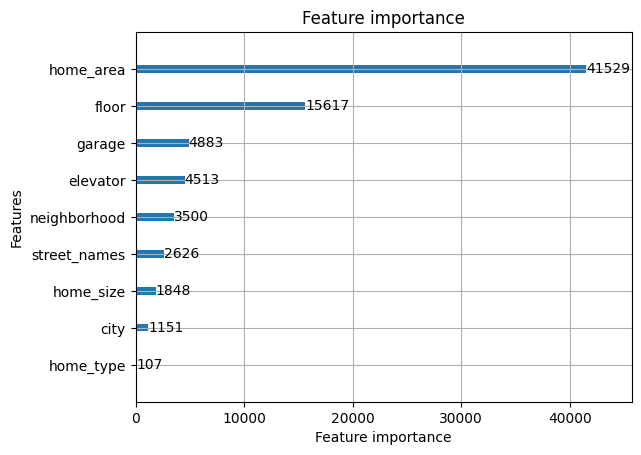

In [ ]:
ax = lgb.plot_importance(best_model, max_num_features=10)
plt.show()


# piecewise optimization 

In [ ]:
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test)

from optuna.integration import LightGBMTuner
optuna.logging.set_verbosity(0)

def tune_hyperparameters(d_train, d_valid):
    params = {
        'objective': 'tweedie',  # or 'tweedie' or any other suitable according to your task
        'metric': 'rmse',           # Evaluation metric
        'boosting_type': 'gbdt',    # Default boosting type
    }

    # Creating the tuner
    tuner = LightGBMTuner(params, 
                          d_train,
                          valid_sets=[d_valid],
                          num_boost_round=1000,
                          show_progress_bar = True)  # Maximum number of boosting iterations

    # Running the tuning
    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    best_booster = tuner.get_best_booster()

    return best_params, best_booster

best_params, best_booster = tune_hyperparameters(d_train, d_valid)


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 832.855884:  14%|#4        | 1/7 [00:01<00:07,  1.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  29%|##8       | 2/7 [00:02<00:05,  1.19s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  43%|####2     | 3/7 [00:03<00:04,  1.19s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  57%|#####7    | 4/7 [00:04<00:03,  1.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  71%|#######1  | 5/7 [00:06<00:02,  1.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


feature_fraction, val_score: 793.865334:  86%|########5 | 6/7 [00:07<00:01,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


num_leaves, val_score: 793.865334:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 784.464823:   5%|5         | 1/20 [00:04<01:23,  4.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 784.464823:  10%|#         | 2/20 [00:08<01:17,  4.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  15%|#5        | 3/20 [00:13<01:13,  4.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730


num_leaves, val_score: 779.788175:  20%|##        | 4/20 [00:13<00:47,  2.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  25%|##5       | 5/20 [00:18<00:53,  3.57s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  30%|###       | 6/20 [00:24<00:59,  4.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  35%|###5      | 7/20 [00:28<00:55,  4.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  40%|####      | 8/20 [00:33<00:53,  4.43s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  45%|####5     | 9/20 [00:35<00:42,  3.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  50%|#####     | 10/20 [00:40<00:40,  4.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  55%|#####5    | 11/20 [00:42<00:32,  3.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  60%|######    | 12/20 [00:47<00:31,  3.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  65%|######5   | 13/20 [00:51<00:27,  3.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  70%|#######   | 14/20 [00:55<00:23,  3.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  75%|#######5  | 15/20 [01:02<00:24,  4.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  80%|########  | 16/20 [01:09<00:22,  5.58s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

num_leaves, val_score: 779.788175:  85%|########5 | 17/20 [01:18<00:20,  6.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  90%|######### | 18/20 [01:23<00:12,  6.18s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

num_leaves, val_score: 779.788175:  95%|#########5| 19/20 [01:28<00:05,  5.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 779.788175:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  10%|#         | 1/10 [00:04<00:40,  4.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  20%|##        | 2/10 [00:09<00:36,  4.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 775.819142:  30%|###       | 3/10 [00:12<00:27,  3.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 775.819142:  40%|####      | 4/10 [00:16<00:24,  4.11s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

bagging, val_score: 775.819142:  50%|#####     | 5/10 [00:18<00:17,  3.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  60%|######    | 6/10 [00:23<00:14,  3.72s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  70%|#######   | 7/10 [00:27<00:11,  3.83s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  80%|########  | 8/10 [00:32<00:08,  4.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

bagging, val_score: 775.819142:  90%|######### | 9/10 [00:36<00:04,  4.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

feature_fraction_stage2, val_score: 775.819142:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

feature_fraction_stage2, val_score: 775.819142:  33%|###3      | 1/3 [00:04<00:08,  4.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

feature_fraction_stage2, val_score: 775.819142:  67%|######6   | 2/3 [00:09<00:04,  4.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 775.819142:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 775.819142:   5%|5         | 1/20 [00:04<01:19,  4.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 5861, number of used features: 9
[LightGBM] [Info] Start training from score 7.753730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
scores = train_and_evaluate(X_test, y_test, best_booster)
display(scores)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'mean_squared_error': 602776.7700695128,
 'root_mean_squared_error': 776.386997617498,
 'mean_absolute_error': 367.0216836685397,
 'median_absolute_error': 134.60877328493183,
 'r2_score': 0.8398658418155807,
 'mean_absolute_percentage_error': 0.1605847610960246,
 'explained_variance_score': 0.8400642395176007,
 'max_error': 7916.031221418012}